In [1]:
!pip install xgboost
!pip install pandas==0.23.4

imports

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3)
from scipy import interp

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, Imputer,OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer,QuantileTransformer
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import make_pipeline,Pipeline

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.metrics import roc_curve, auc

from itertools import cycle

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split 
from sklearn.model_selection import KFold,RandomizedSearchCV, cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA, TruncatedSVD

import glob

from xgboost import XGBClassifier

from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_classif, SelectPercentile, chi2
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline

In [4]:
source_dir = "dataset"
suffix_train = "/train/"
suffix_test =  "/test/"

filname_subs_features_train = "subs_features_train.csv"
filname_subs_bs_cons_train = "subs_bs_consumption_train.csv"
filname_subs_bs_data_session_train = "subs_bs_data_session_train.csv"
filname_subs_bs_voice_session_train = "subs_bs_voice_session_train.csv"


filname_subs_features_test= "subs_features_test.csv"
filname_subs_bs_cons_test = "subs_bs_consumption_test.csv"
filname_subs_bs_data_session_test = "subs_bs_data_session_test.csv"
filname_subs_bs_voice_session_test = "subs_bs_voice_session_test.csv"

filname_y_train = "subs_csi_train.csv"
filname_y_test = "subs_csi_test.csv"

filename_bs_avg_kpi = "bs_avg_kpi.csv"

target = "CSI"
seed = 33

Считаем train/test файлы.

In [5]:
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%y')

#features
df_sfeatures_train = pd.read_csv(source_dir + suffix_train + filname_subs_features_train, 
                             header=0, sep = ';', decimal=",")

df_sfeatures_test = pd.read_csv(source_dir + suffix_test + filname_subs_features_test, 
                             header=0, sep = ';', decimal=",")

#bs consumption
df_bsconsumption_train = pd.read_csv(source_dir + suffix_train + filname_subs_bs_cons_train, 
                             header=0, sep = ';', decimal=",")

df_bsconsumption_test = pd.read_csv(source_dir + suffix_test + filname_subs_bs_cons_test, 
                             header=0, sep = ';', decimal=",")

#data session
df_datasession_train = pd.read_csv(source_dir + suffix_train + filname_subs_bs_data_session_train, 
                             header=0, sep = ';', decimal=",")

df_datasession_test = pd.read_csv(source_dir + suffix_test + filname_subs_bs_data_session_test, 
                             header=0, sep = ';', decimal=",")


#voice session
df_voicesession_train = pd.read_csv(source_dir + suffix_train + filname_subs_bs_voice_session_train, 
                             header=0, sep = ';', decimal=",")

df_voicesession_test = pd.read_csv(source_dir + suffix_test + filname_subs_bs_voice_session_test, 
                             header=0, sep = ';', decimal=",")



# results
df_y_train = pd.read_csv(source_dir + suffix_train + filname_y_train, 
                             header=0, sep = ';', decimal=",")

df_y_test_pred = pd.read_csv(source_dir + suffix_test + filname_y_test, 
                             header=0, sep = ';', decimal=",")

In [6]:
'''%%time
# try to read large csv using chunks
df_bs_avg_kpi = pd.read_csv(source_dir + '/' +filename_bs_avg_kpi, 
                             header=0, sep = ';', decimal=",", nrows=10000)


ffpath = "dataset/preprocessed/"
chunk_size = 500000
appended_data = []
i = 0
for gm_chunk in pd.read_csv(source_dir + '/' +filename_bs_avg_kpi,header=0, 
                            sep = ';', decimal=",", chunksize = chunk_size):
    i+=1
    gm_chunk[['T_DATE']] = gm_chunk['T_DATE'].str.split('.',expand=True)[1] # getting only months
    gm_chunk.rename(columns={'T_DATE':'T_DATE_month'}, inplace=True)
    gm_chunk.groupby(['T_DATE_month','CELL_LAC_ID'],sort=False,as_index = False).mean()
    gm_chunk = pd.DataFrame(gm_chunk)
    gm_chunk.to_csv(ffpath + i + ".csv", sep='\t', encoding='utf-8',index = False, header = False)
    #appended_data.append(gm_chunk)'''

'%%time\n# try to read large csv using chunks\ndf_bs_avg_kpi = pd.read_csv(source_dir + \'/\' +filename_bs_avg_kpi, \n                             header=0, sep = \';\', decimal=",", nrows=10000)\n\n\nffpath = "dataset/preprocessed/"\nchunk_size = 500000\nappended_data = []\ni = 0\nfor gm_chunk in pd.read_csv(source_dir + \'/\' +filename_bs_avg_kpi,header=0, \n                            sep = \';\', decimal=",", chunksize = chunk_size):\n    i+=1\n    gm_chunk[[\'T_DATE\']] = gm_chunk[\'T_DATE\'].str.split(\'.\',expand=True)[1] # getting only months\n    gm_chunk.rename(columns={\'T_DATE\':\'T_DATE_month\'}, inplace=True)\n    gm_chunk.groupby([\'T_DATE_month\',\'CELL_LAC_ID\'],sort=False,as_index = False).mean()\n    gm_chunk = pd.DataFrame(gm_chunk)\n    gm_chunk.to_csv(ffpath + i + ".csv", sep=\'\t\', encoding=\'utf-8\',index = False, header = False)\n    #appended_data.append(gm_chunk)'

#### Test voice/data sessions.

In [7]:
# сливаем два массива в 1
df_datasession = pd.concat([df_datasession_train,df_datasession_test], axis=0, sort = False)
df_voicesession = pd.concat([df_voicesession_train,df_voicesession_test], axis=0, sort = False)

del df_datasession_train
del df_datasession_test
del df_voicesession_train
del df_voicesession_test

In [8]:
'''for_test_data = df_datasession[df_datasession['SK_ID'] == 1827]
for_test_voice = df_voicesession[df_voicesession['SK_ID'] == 1827]


for_test_data = for_test_data.groupby(['SK_ID','CELL_LAC_ID'],sort=False,as_index = False).agg({
    'DATA_VOL_MB' : ['sum','count'],# total minutes by all cells
    #'DATA_VOL_MB' : ['count']# total minutes by all cells
})

for_test_voice = for_test_voice.groupby(['SK_ID','CELL_LAC_ID'],sort=False,as_index = False).agg({
    'VOICE_DUR_MIN' : ['sum','count'],# total minutes by all cells
    #'DATA_VOL_MB' : ['count']# total minutes by all cells
})

for_test_data.columns = for_test_data.columns.droplevel(1)
for_test_data.columns = ['SK_ID', 'CELL_LAC_ID', 'DATA_VOL_MB_BY_CELL', 'FREQ_BY_CELL']

for_test_voice.columns = for_test_voice.columns.droplevel(1)
for_test_voice.columns = ['SK_ID', 'CELL_LAC_ID', 'VOICE_DUR_MIN_BY_CELL', 'FREQ_BY_CELL']

for_test_data = for_test_data.sort_values(by = 'FREQ_BY_CELL',axis=0, ascending=False)
for_test_voice = for_test_voice.sort_values(by = 'FREQ_BY_CELL',axis=0, ascending=False)

for_test = pd.merge(for_test_data, for_test_voice,  on=['CELL_LAC_ID'],how = 'left')

for_test.drop(['SK_ID_y'],axis = 1, inplace = True)

for_test.sort_values(by = ['FREQ_BY_CELL_x','FREQ_BY_CELL_y'],axis=0, ascending=False)'''

"for_test_data = df_datasession[df_datasession['SK_ID'] == 1827]\nfor_test_voice = df_voicesession[df_voicesession['SK_ID'] == 1827]\n\n\nfor_test_data = for_test_data.groupby(['SK_ID','CELL_LAC_ID'],sort=False,as_index = False).agg({\n    'DATA_VOL_MB' : ['sum','count'],# total minutes by all cells\n    #'DATA_VOL_MB' : ['count']# total minutes by all cells\n})\n\nfor_test_voice = for_test_voice.groupby(['SK_ID','CELL_LAC_ID'],sort=False,as_index = False).agg({\n    'VOICE_DUR_MIN' : ['sum','count'],# total minutes by all cells\n    #'DATA_VOL_MB' : ['count']# total minutes by all cells\n})\n\nfor_test_data.columns = for_test_data.columns.droplevel(1)\nfor_test_data.columns = ['SK_ID', 'CELL_LAC_ID', 'DATA_VOL_MB_BY_CELL', 'FREQ_BY_CELL']\n\nfor_test_voice.columns = for_test_voice.columns.droplevel(1)\nfor_test_voice.columns = ['SK_ID', 'CELL_LAC_ID', 'VOICE_DUR_MIN_BY_CELL', 'FREQ_BY_CELL']\n\nfor_test_data = for_test_data.sort_values(by = 'FREQ_BY_CELL',axis=0, ascending=False)\nfor

In [9]:
#False for ranks by high (1) to low (N)
'''
for_test['rank'] = for_test['SUM_MINUTES'].rank(ascending=True,method = 'dense')
for_test['rank2'] = for_test['SUM_DATA_MB'].rank(ascending=True,method = 'dense')
for_test['rank3'] = for_test['SUM_DATA_MIN'].rank(ascending=True,method = 'dense')
for_test['result_rank'] = for_test['rank'].values + for_test['rank2'].values + for_test['rank3'].values
for_test.drop(['rank','rank2','rank3'],axis = 1, inplace = True)
for_test[for_test.result_rank > 300].sort_values('result_rank')

#df_bsconsumption_train['CELL_MAX_MINUTES_ID'] 
#cell with max minutes
max_ind = for_test.SUM_MINUTES.idxmax()
print (
for_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_MINUTES']]
)


#cell with max data
max_ind = for_test.SUM_DATA_MB.idxmax()
print (
for_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_DATA_MB']]
)

#cell with length session
max_ind = for_test.SUM_DATA_MIN.idxmax()
print (
for_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_DATA_MIN']]
)



#cell with min minutes
max_ind = for_test.SUM_MINUTES.idxmin()
print (
for_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_MINUTES']]
)


#cell with min data
max_ind = for_test.SUM_DATA_MB.idxmin()
print (
for_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_DATA_MB']]
)

#cell with length session
max_ind = for_test.SUM_DATA_MIN.idxmin()
print (
for_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_DATA_MIN']]
)'''

"\nfor_test['rank'] = for_test['SUM_MINUTES'].rank(ascending=True,method = 'dense')\nfor_test['rank2'] = for_test['SUM_DATA_MB'].rank(ascending=True,method = 'dense')\nfor_test['rank3'] = for_test['SUM_DATA_MIN'].rank(ascending=True,method = 'dense')\nfor_test['result_rank'] = for_test['rank'].values + for_test['rank2'].values + for_test['rank3'].values\nfor_test.drop(['rank','rank2','rank3'],axis = 1, inplace = True)\nfor_test[for_test.result_rank > 300].sort_values('result_rank')\n\n#df_bsconsumption_train['CELL_MAX_MINUTES_ID'] \n#cell with max minutes\nmax_ind = for_test.SUM_MINUTES.idxmax()\nprint (\nfor_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_MINUTES']]\n)\n\n\n#cell with max data\nmax_ind = for_test.SUM_DATA_MB.idxmax()\nprint (\nfor_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_DATA_MB']]\n)\n\n#cell with length session\nmax_ind = for_test.SUM_DATA_MIN.idxmax()\nprint (\nfor_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_DATA_MIN']]\n)\n

Считаем трейн/тест наборы данных из таблиц subs_features, subs_bs_consumption.

subs_features: 
В таблице содержится информация о динамике изменения коммерческих характеристик абонентов, прошедших опрос CSI за последний год до опроса. Временная гранулярность данных =  месяц. Уровень агрегации = абонент.

subs_bs_consumption:
В таблице содержится информация об объеме потребления сервисов (голос, данные на всех сотах) абонентами, прошедшими опрос CSI за последние три месяца до опроса. Временная гранулярность = месяц Уровень агрегации = абонент / сота.



In [10]:
# сливаем два массива в 1
df_bsconsumption = pd.concat([df_bsconsumption_train,df_bsconsumption_test], axis=0, sort = False)

# delete temp dfs, for best memory usage
del df_bsconsumption_train
del df_bsconsumption_test

Предобработаем таблицу, аггрегируем данные по месяцам и SK_ID абонента:
- выделим кол-во сот за месяц по абоненту, и суммы количественных характеристик.

In [11]:
df_bsconsumption.MON = df_bsconsumption.MON.str.split('.0',expand=True)[1] # getting only months

# производим аггрегацию
df_bsconsumption = df_bsconsumption.groupby(['SK_ID','MON'],sort=False,as_index = False).agg({
    'CELL_LAC_ID' : 'count', # get count of cells by sk_id, some kind of activity
    'SUM_MINUTES' : ['sum'],# total minutes by all cells
    'SUM_DATA_MB' : ['sum'],#  total data by all cells
    'SUM_DATA_MIN' : ['sum']# total cells length
    # max cell with minutes, data, data_min
    #'CELL_LAC_ID' : ['']
   
})

df_bsconsumption.columns = df_bsconsumption.columns.droplevel(1)

df_bsconsumption.columns = ['SK_ID', 'Month_Snap_Date', 'CELLS_COUNT', 'SUM_MINUTES', 'SUM_DATA_MB','SUM_DATA_MIN']

df_bsconsumption.Month_Snap_Date = df_bsconsumption.Month_Snap_Date.astype(np.int16)

Теперь загрузим основной датасет, subs_features.csv.

In [12]:
df_union_train = pd.merge(df_y_train, df_sfeatures_train, on=['SK_ID'])

In [13]:
df_union_test = pd.merge(df_y_test_pred,df_sfeatures_test, on=['SK_ID'])

In [14]:
df = pd.concat([df_union_train,df_union_test], axis=0, sort = False)

In [15]:
del df_union_train

In [16]:
del df_union_test

Посмотрим на его состав:

In [17]:
df.shape

(106400, 38)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106400 entries, 0 to 58988
Data columns (total 38 columns):
SK_ID               106400 non-null int64
CSI                 47411 non-null float64
CONTACT_DATE        106400 non-null object
SNAP_DATE           106400 non-null object
COM_CAT#1           106400 non-null int64
COM_CAT#2           106400 non-null int64
COM_CAT#3           106400 non-null int64
BASE_TYPE           106400 non-null int64
ACT                 106400 non-null int64
ARPU_GROUP          106358 non-null float64
COM_CAT#7           106400 non-null int64
COM_CAT#8           101541 non-null float64
DEVICE_TYPE_ID      106098 non-null float64
INTERNET_TYPE_ID    106098 non-null float64
REVENUE             106400 non-null float64
ITC                 106400 non-null float64
VAS                 106400 non-null float64
RENT_CHANNEL        106400 non-null float64
ROAM                106400 non-null float64
COST                106400 non-null float64
COM_CAT#17          106400 

Увеличим максимально количество отображаемых колонок.

In [19]:
pd.set_option('display.max_columns', df.shape[1])

Чтобы удобнее было обращаться к колонкам заменим знак шарпа на _.

In [20]:
df.columns = df.columns.str.replace("[#]", "_")

In [21]:
df.head()

,SK_ID,CSI,CONTACT_DATE,SNAP_DATE,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_24,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34
0,2,0.0,04.05,01.03.02,7,77,10,1,1,10.0,2,1318.0,5.0,2.0,0.133708,0.007335,0.084167,0.055325,0.0,0.004982,0.0,0.0,0.026212,0.706893,0.019298,0.706893,0.133897,31.12,1,1,0.002070,0.007335,0.000050,0.002785,0.029765,0.027579,0.103896,NaN
1,2,0.0,04.05,01.02.02,7,77,9,1,1,10.0,2,1318.0,5.0,2.0,0.134224,0.001590,0.084167,0.055312,0.0,0.004396,0.0,0.0,0.026212,0.707528,0.019298,0.707528,0.134836,31.12,1,1,0.003913,0.001590,0.000018,0.001954,0.054871,0.027579,0.103896,NaN
2,2,0.0,04.05,01.05.02,7,77,12,1,1,9.0,2,1318.0,5.0,2.0,0.128917,0.008331,0.084167,0.055257,0.0,0.005078,0.0,0.0,0.026212,0.705129,0.019298,0.705129,0.129093,31.12,1,1,0.001801,0.008317,0.000081,0.002441,0.018126,0.027579,0.103896,9.0
3,2,0.0,04.05,01.01.02,7,77,17,1,1,6.0,2,1318.0,5.0,2.0,0.117077,0.002301,0.084167,0.055353,0.0,0.004471,0.0,0.0,0.087185,0.701424,0.086379,0.697846,0.118129,31.12,1,0,0.001798,0.002048,0.000033,0.002331,0.022108,0.027579,0.103896,NaN
4,2,0.0,04.05,01.04.02,7,77,11,1,1,8.0,2,1318.0,5.0,2.0,0.126715,0.002080,0.084167,0.055187,0.0,0.004436,0.0,0.0,0.026212,0.704850,0.019298,0.704850,0.126587,31.12,1,1,0.006520,0.001408,0.000010,0.001709,0.022772,0.027579,0.103896,9.0


In [22]:
df.tail()

,SK_ID,CSI,CONTACT_DATE,SNAP_DATE,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_24,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34
58984,6156,NaN,14.04,01.03.02,4,54,5,2,1,4.0,3,1324.0,5.0,2.0,0.110392,0.000728,0.084167,0.054969,0.0,0.004281,0.0,0.0,0.026212,0.699214,0.019298,0.699214,0.111080,31.12,1,1,0.003236,0.000728,0.000000,0.000000,0.003116,0.027579,0.103896,10.0
58985,6156,NaN,14.04,01.08.01,4,54,5,2,1,1.0,3,1324.0,5.0,2.0,0.108153,0.000000,0.084167,0.054966,0.0,0.004206,0.0,0.0,0.026212,0.698482,0.019298,0.698482,0.109461,31.12,1,1,0.000569,0.000000,0.000000,0.000000,0.000862,0.027579,0.103896,9.0
58986,6156,NaN,14.04,01.05.01,4,54,5,2,1,2.0,3,1324.0,5.0,2.0,0.108803,0.002199,0.084418,0.055716,0.0,0.004506,0.0,0.0,0.026212,0.698480,0.019298,0.698480,0.109534,31.12,1,1,0.003103,0.002199,0.001328,0.005336,0.023826,0.027579,0.103896,2.0
58987,6156,NaN,14.04,01.04.02,4,54,5,2,1,1.0,3,1324.0,5.0,2.0,0.108261,0.000000,0.084167,0.054968,0.0,0.004207,0.0,0.0,0.026212,0.698520,0.019298,0.698520,0.109409,31.12,1,1,0.001198,0.000000,0.000000,0.000000,0.002594,0.027579,0.103896,10.0
58988,6156,NaN,14.04,01.10.01,4,54,5,2,1,4.0,3,1324.0,5.0,2.0,0.110345,0.000177,0.084167,0.054971,0.0,0.004225,0.0,0.0,0.026212,0.699241,0.019298,0.699241,0.109618,31.12,1,1,0.009500,0.000000,0.000000,0.000000,0.005362,0.027579,0.103896,9.0


In [23]:
df.describe()

,SK_ID,CSI,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34
count,106400.000000,47411.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106358.000000,106400.000000,101541.000000,106098.000000,106098.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,102936.000000
mean,4876.034201,0.156694,4.503421,41.075367,5.271100,1.939070,0.990705,7.580370,2.400451,870.832580,4.610162,1.908113,0.128907,0.018490,0.087468,0.057185,0.000050,0.006531,0.003301,0.003521,0.026593,0.704000,0.019748,0.703853,0.126349,0.999878,0.988769,0.016675,0.017986,0.004444,0.004695,0.045831,0.028238,0.104961,5.582323
std,2812.580460,0.363515,2.182422,22.237932,2.783232,0.239204,0.095962,3.231712,1.625670,515.018465,0.898524,0.726753,0.020725,0.031818,0.012046,0.012992,0.003958,0.005383,0.020150,0.026469,0.010831,0.006346,0.004545,0.006369,0.018020,0.011053,0.105381,0.024760,0.030927,0.015495,0.021385,0.051868,0.009022,0.009838,3.557936
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2436.000000,0.000000,3.000000,25.000000,5.000000,2.000000,1.000000,5.000000,1.000000,391.000000,5.000000,1.000000,0.115454,0.001027,0.084167,0.054996,0.000000,0.004429,0.000000,0.000000,0.026212,0.700358,0.019298,0.700214,0.115037,1.000000,1.000000,0.002037,0.000960,0.000000,0.000000,0.010774,0.027579,0.103896,2.000000
50%,4889.000000,0.000000,4.000000,38.000000,5.000000,2.000000,1.000000,8.000000,2.000000,926.000000,5.000000,2.000000,0.124508,0.006953,0.084212,0.055156,0.000000,0.005209,0.000000,0.000000,0.026212,0.702849,0.019298,0.702705,0.122497,1.000000,1.000000,0.008221,0.006679,0.000070,0.000000,0.030382,0.027579,0.103896,4.000000
75%,7310.000000,0.000000,6.000000,60.000000,5.000000,2.000000,1.000000,10.000000,3.000000,1318.000000,5.000000,2.000000,0.136094,0.022675,0.086573,0.056061,0.000000,0.007087,0.000000,0.000000,0.026212,0.705948,0.019298,0.705816,0.131878,1.000000,1.000000,0.021532,0.022035,0.002882,0.000190,0.062889,0.027579,0.103896,9.000000
max,9748.000000,1.000000,8.000000,83.000000,17.000000,2.000000,1.000000,12.000000,9.000000,1702.000000,8.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000


Посчитаем количество пропущенных переменных.

In [24]:
print (pd.concat([1- df.count() / df.shape[0], df.isna().sum()],axis=1))

                         0      1
SK_ID             0.000000      0
CSI               0.554408  58989
CONTACT_DATE      0.000000      0
SNAP_DATE         0.000000      0
COM_CAT_1         0.000000      0
COM_CAT_2         0.000000      0
COM_CAT_3         0.000000      0
BASE_TYPE         0.000000      0
ACT               0.000000      0
ARPU_GROUP        0.000395     42
COM_CAT_7         0.000000      0
COM_CAT_8         0.045667   4859
DEVICE_TYPE_ID    0.002838    302
INTERNET_TYPE_ID  0.002838    302
REVENUE           0.000000      0
ITC               0.000000      0
VAS               0.000000      0
RENT_CHANNEL      0.000000      0
ROAM              0.000000      0
COST              0.000000      0
COM_CAT_17        0.000000      0
COM_CAT_18        0.000000      0
COM_CAT_19        0.000000      0
COM_CAT_20        0.000000      0
COM_CAT_21        0.000000      0
COM_CAT_22        0.000000      0
COM_CAT_23        0.000000      0
COM_CAT_24        0.000000      0
COM_CAT_25    

Пропуски есть, но не критично.

CSI содержит пропуски, но только потому, что я подключил subs_csi_test.csv в самом начале, для контроля последовательности SK_ID в ответах.

Выделим какой-нибудь SK_ID и посмотрим данные по абоненту:

In [25]:
df[df.SK_ID == 1827].sort_values('SNAP_DATE',ascending=False) #3608

,SK_ID,CSI,CONTACT_DATE,SNAP_DATE,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_24,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34
18650,1827,1.0,01.05,01.12.01,6,25,4,2,1,7.0,1,756.0,5.0,2.0,0.121161,0.009813,0.084795,0.055439,0.0,0.005284,0.0,0.0,0.026212,0.702234,0.019298,0.702234,0.119433,31.12,1,1,0.005435,0.009813,0.001672,0.001295,0.040953,0.027579,0.103896,2.0
18643,1827,1.0,01.05,01.11.01,6,25,4,2,1,6.0,1,756.0,5.0,2.0,0.119344,0.003228,0.084640,0.055376,0.0,0.004599,0.0,0.0,0.026212,0.702125,0.019298,0.702125,0.119694,31.12,1,1,0.004891,0.003228,0.001322,0.001813,0.028326,0.027579,0.103896,2.0
18645,1827,1.0,01.05,01.10.01,6,25,4,2,1,6.0,1,756.0,5.0,2.0,0.120023,0.009799,0.084552,0.055601,0.0,0.005280,0.0,0.0,0.026212,0.701837,0.019298,0.701837,0.119015,31.12,1,1,0.010658,0.009434,0.000735,0.007679,0.035470,0.027579,0.103896,2.0
18647,1827,1.0,01.05,01.09.01,6,25,4,2,1,6.0,1,756.0,5.0,2.0,0.119355,0.004656,0.085421,0.055995,0.0,0.004844,0.0,0.0,0.026212,0.701938,0.019298,0.701938,0.119972,31.12,1,1,0.003636,0.004656,0.002275,0.003157,0.029004,0.027579,0.103896,2.0
18642,1827,1.0,01.05,01.08.01,6,25,4,2,1,7.0,1,756.0,5.0,2.0,0.120577,0.009197,0.085008,0.056170,0.0,0.005293,0.0,0.0,0.026212,0.702021,0.019298,0.702021,0.121121,31.12,1,1,0.003466,0.009122,0.001675,0.003589,0.046710,0.027579,0.103896,2.0
18644,1827,1.0,01.05,01.07.01,6,25,3,2,1,6.0,1,756.0,5.0,2.0,0.119358,0.003931,0.085070,0.055565,0.0,0.004713,0.0,0.0,0.026212,0.702041,0.019298,0.702041,0.119972,31.12,1,1,0.003206,0.003931,0.000915,0.002945,0.036663,0.027579,0.103896,2.0
18641,1827,1.0,01.05,01.06.01,6,25,3,2,1,6.0,1,756.0,5.0,2.0,0.117526,0.001007,0.084167,0.055722,0.0,0.004369,0.0,0.0,0.026212,0.701661,0.019298,0.701661,0.118911,31.12,1,1,0.000343,0.001007,0.001018,0.004174,0.025330,0.027579,0.103896,2.0
18649,1827,1.0,01.05,01.05.02,6,25,5,2,1,9.0,1,756.0,5.0,2.0,0.128572,0.001103,0.084167,0.057550,0.0,0.004523,0.0,0.0,0.026212,0.705437,0.019298,0.705437,0.129110,31.12,1,1,0.003790,0.001103,0.008316,0.011717,0.016630,0.027579,0.103896,2.0
18652,1827,1.0,01.05,01.04.02,6,25,5,2,1,8.0,1,756.0,5.0,2.0,0.128366,0.015456,0.086449,0.056589,0.0,0.006058,0.0,0.0,0.026212,0.704176,0.019298,0.704176,0.128031,31.12,1,1,0.006489,0.015456,0.006481,0.005560,0.047019,0.027579,0.103896,2.0
18646,1827,1.0,01.05,01.03.02,6,25,5,2,1,7.0,1,756.0,5.0,2.0,0.123162,0.008165,0.089613,0.055791,0.0,0.005460,0.0,0.0,0.026212,0.702804,0.019298,0.702804,0.122305,31.12,1,1,0.007932,0.008165,0.002462,0.005459,0.034097,0.027579,0.103896,2.0


#### Time features.

В первую очередь, посмотрим на данные, которые связаны со временем:

CONTACT_DATE, SNAP_DATE, COM_CAT_24.

SNAP_DATE - дата сбора параметров, попробуем распарсить её и выделить месяц, год.

День здесь не так интересен, т.к. дата сбора данных всегда 1 число месяца.

In [26]:
df.SNAP_DATE.unique()

array(['01.03.02', '01.02.02', '01.05.02', '01.01.02', '01.04.02',
       '01.12.01', '01.10.01', '01.09.01', '01.11.01', '01.08.01',
       '01.07.01', '01.06.01', '01.05.01'], dtype=object)

In [27]:
df.SNAP_DATE.value_counts()

01.04.02    9369
01.03.02    9274
01.02.02    9134
01.01.02    9038
01.12.01    8961
01.11.01    8857
01.10.01    8783
01.09.01    8689
01.08.01    8591
01.07.01    8484
01.06.01    8367
01.05.02    4524
01.05.01    4329
Name: SNAP_DATE, dtype: int64

In [28]:
df.SNAP_DATE = pd.to_datetime(df.SNAP_DATE, format='%d.%m.%y')

In [29]:
df['Year_Snap_Date']=df.SNAP_DATE.dt.year #encode 2017 as 0 and 2018 as 1
df['Month_Snap_Date']=df.SNAP_DATE.dt.month
df['Year_Snap_Date'] = pd.Categorical(df['Year_Snap_Date'])
df['Year_Snap_Date'] = df['Year_Snap_Date'].cat.codes

In [30]:
df.drop(['SNAP_DATE'],axis = 1 , inplace = True)

Посмотрим на величину COM_CAT_24.

In [31]:
df.COM_CAT_24.unique()

array(['31.12', '06.05', '27.05', '30.05', '28.05', '29.05', '23.05',
       '24.05', '12.04', '15.04', '19.04', '23.04', '22.04', '08.04'],
      dtype=object)

In [32]:
df.COM_CAT_24.value_counts()

31.12    106387
19.04         1
27.05         1
08.04         1
15.04         1
06.05         1
22.04         1
24.05         1
28.05         1
29.05         1
12.04         1
23.05         1
23.04         1
30.05         1
Name: COM_CAT_24, dtype: int64

Дропнем этот признак, т.к. он по сути состоит только из одного значения.

In [33]:
df.drop('COM_CAT_24', axis = 1, inplace = True)

Посмотрим теперь на Contact Date.

In [34]:
df.CONTACT_DATE = pd.to_datetime(df.CONTACT_DATE, format='%d.%m')

In [35]:
df['Month_CONTACT_DATE']=df.CONTACT_DATE.dt.month
df['Day_CONTACT_DATE']=df.CONTACT_DATE.dt.day 

In [36]:
df.CONTACT_DATE.value_counts()

1900-05-12    2858
1900-04-24    2436
1900-04-07    2409
1900-04-09    2365
1900-05-08    2347
1900-04-13    2337
1900-04-05    2302
1900-04-23    2276
1900-05-13    2267
1900-04-11    2185
1900-04-04    2180
1900-04-14    2164
1900-04-20    2153
1900-04-06    2131
1900-04-25    2070
1900-04-17    2052
1900-04-26    2049
1900-04-27    1995
1900-05-17    1990
1900-05-09    1985
1900-04-21    1952
1900-04-12    1938
1900-05-02    1937
1900-04-19    1932
1900-05-11    1906
1900-04-16    1897
1900-04-15    1889
1900-05-04    1878
1900-04-18    1878
1900-05-05    1872
1900-05-10    1849
1900-05-14    1831
1900-04-03    1813
1900-04-22    1795
1900-04-01    1792
1900-04-10    1767
1900-05-22    1760
1900-05-03    1725
1900-05-01    1715
1900-05-30    1689
1900-05-28    1687
1900-05-07    1679
1900-05-21    1672
1900-05-06    1665
1900-04-02    1651
1900-05-16    1644
1900-05-27    1622
1900-05-24    1555
1900-05-29    1548
1900-04-08    1474
1900-05-25    1449
1900-05-26    1396
1900-05-19  

In [37]:
df.drop('CONTACT_DATE', axis = 1, inplace = True)

Также объединим полученный датасет с df_bsconsumption.

In [38]:
# аттачим к датасету df_bsconsumption
df = pd.merge(df,df_bsconsumption, on=['SK_ID','Month_Snap_Date'],how = 'left') #on=['A', 'B']

Посмотрим теперь на признаки.

Для начала, глянем на примере статистик выдаваемых describe-методом есть ли какие различия между довольными/недовольными клиентами.

Такой метод хоть и не очень хорош, но можно качественно попробовать оценить разницу.

In [39]:
df_good = df[df.CSI == 0]
df_bad = df[df.CSI == 1]

In [40]:
df_good.describe() - df_bad.describe()

,SK_ID,CSI,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,...,COM_CAT_23,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34,Year_Snap_Date,Month_Snap_Date,Month_CONTACT_DATE,Day_CONTACT_DATE,CELLS_COUNT,SUM_MINUTES,SUM_DATA_MB,SUM_DATA_MIN
count,32553.000000,32553.0,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32540.000000,32553.000000,32489.000000,32486.000000,32486.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,...,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,31378.000000,32553.000000,32553.000000,32553.0,32553.000000,8510.000000,8510.000000,8510.000000,8510.000000
mean,-12.121475,-1.0,-0.039435,1.447129,0.044154,-0.010112,0.004384,-0.405237,-0.051390,10.612543,-0.051850,0.008863,-0.002847,-0.003107,0.000191,-0.002001,-0.000002,-0.000464,0.000680,...,-0.002531,0.000144,-0.001760,-0.001259,-0.003268,0.000575,0.000198,-0.004449,0.000040,-0.000461,0.173638,0.003299,-0.014477,0.0,0.066970,-10.879567,-0.007048,0.002580,-0.041349
std,8.335166,0.0,-0.214598,-0.153809,0.136852,0.019166,-0.021078,0.009421,-0.173336,-8.506106,0.060924,0.047478,-0.003363,-0.001930,0.002801,-0.018878,0.003070,0.001421,0.005552,...,-0.003587,-0.005224,0.008261,-0.001372,-0.003292,0.006966,0.001487,-0.005595,0.003152,-0.002155,0.033193,0.000428,0.001503,0.0,0.149023,5.184999,-0.000464,0.011654,-0.015843
min,-4.000000,-1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-0.072962,0.000000,-0.018915,0.001785,0.000000,-0.000789,0.000000,...,-0.063800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007143,0.090927,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.250000,-1.0,0.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,41.000000,0.000000,0.000000,-0.001542,-0.000539,0.000000,-0.000016,0.000000,-0.000075,0.000000,...,-0.001445,0.000000,0.000000,-0.000381,-0.000455,0.000000,0.000000,-0.000975,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-1.500000,-0.003192,0.000000,0.000000
50%,-40.000000,-1.0,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,-0.002019,-0.002175,0.000072,-0.000142,0.000000,-0.000241,0.000000,...,-0.001496,0.000000,0.000000,-0.000583,-0.002052,-0.000294,0.000000,-0.004498,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-13.000000,-0.010864,-0.001548,-0.067975
75%,-31.250000,-1.0,-1.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-0.003217,-0.005198,0.000200,-0.000319,0.000000,-0.000629,0.000000,...,-0.002654,0.000000,0.000000,-0.001902,-0.005066,-0.000891,-0.000533,-0.006571,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,-30.000000,-0.013833,-0.000677,-0.117710
max,1.000000,-1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.374654,0.134999,0.652374,-0.194458,0.843204,0.838044,0.597248,...,0.382603,0.000000,0.000000,0.391562,0.034857,0.754211,0.444073,-0.269832,0.257584,0.114306,0.000000,0.000000,0.000000,0.0,0.000000,679.000000,0.017430,1.075646,0.003482


In [41]:
del df_good
del df_bad

Каких-либо интересныз различий не замечено.

Построим гистограммы, чтобы оценить распределия признаков.

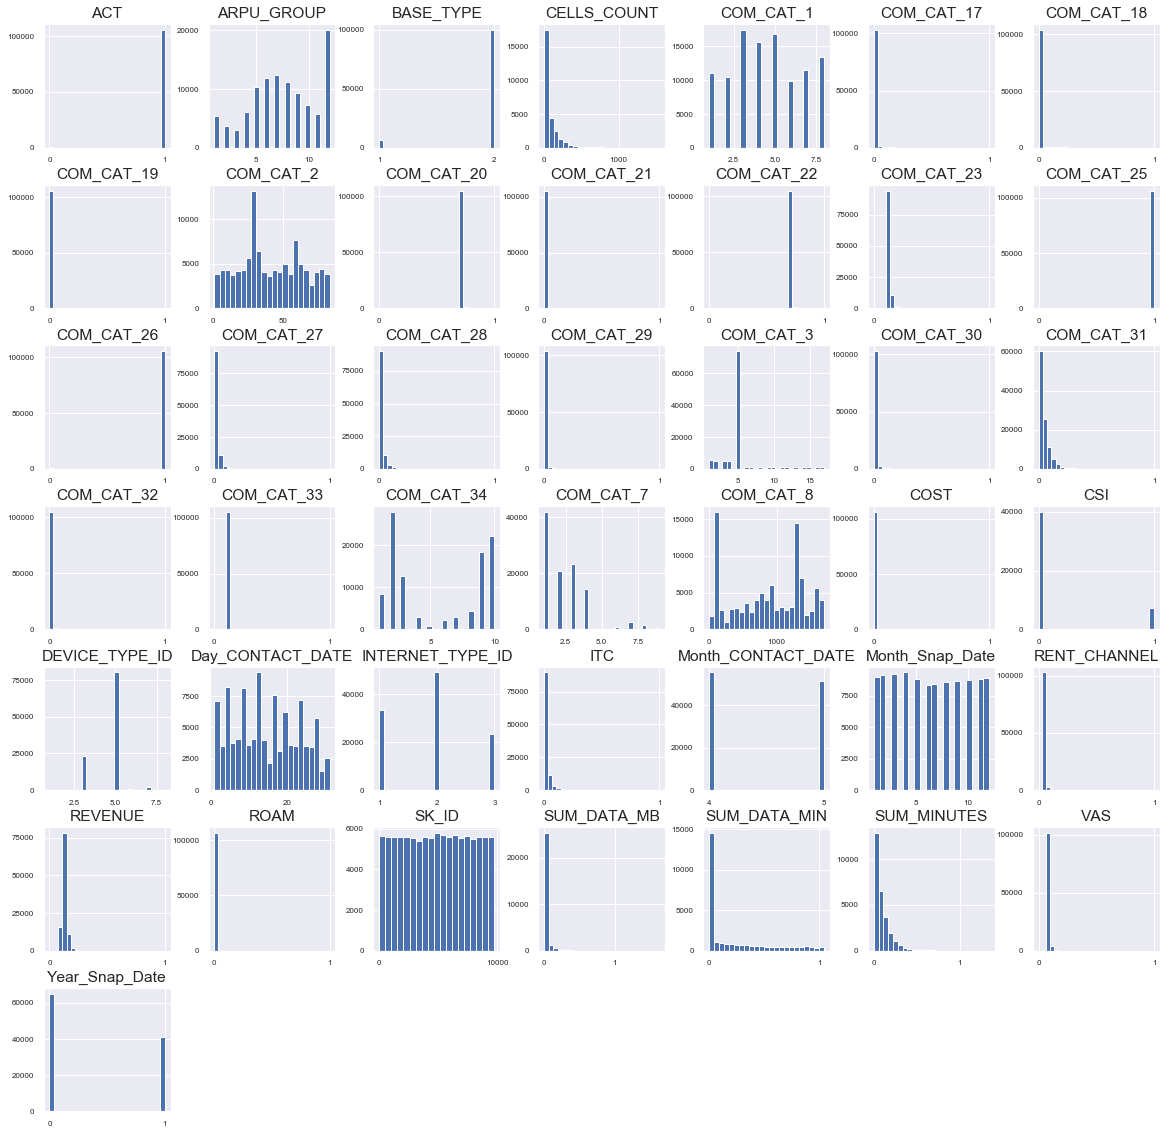

In [42]:
df.hist(figsize=(20, 20), bins='doane', xlabelsize=8, ylabelsize=8);

Также дополнительно посчитаем распределение значений в виде чисел.

In [43]:
for i, col in enumerate(df.columns.drop([target,'SK_ID'])):
    print(df[col].value_counts(normalize = True))

3    0.163976
5    0.158524
4    0.147650
8    0.126137
7    0.108327
1    0.103835
2    0.098064
6    0.093487
Name: COM_CAT_1, dtype: float64
30    0.103835
60    0.036513
32    0.027209
25    0.019737
43    0.018853
63    0.016795
77    0.014596
54    0.014549
28    0.014154
66    0.014135
40    0.014107
52    0.013976
15    0.013759
57    0.013647
68    0.013430
3     0.013299
65    0.012932
53    0.012679
24    0.012669
34    0.012641
4     0.011701
82    0.011476
59    0.011429
33    0.010883
20    0.010855
55    0.010855
58    0.010846
44    0.010836
14    0.010799
62    0.010658
        ...   
7     0.009868
18    0.009859
10    0.009840
23    0.009774
19    0.009709
78    0.009680
35    0.009521
11    0.009511
50    0.009483
2     0.009445
47    0.009398
5     0.009398
17    0.009342
31    0.009305
46    0.009267
22    0.009239
74    0.009192
49    0.009192
37    0.009098
64    0.009088
36    0.008957
76    0.008769
79    0.008562
73    0.007838
29    0.006184
81    0.004126
7

0.000000    0.065291
0.000003    0.000996
0.000006    0.000630
0.000043    0.000620
0.000071    0.000536
0.000139    0.000508
0.000060    0.000508
0.000037    0.000508
0.000100    0.000498
0.000122    0.000489
0.000134    0.000489
0.000034    0.000489
0.000046    0.000489
0.000119    0.000470
0.000131    0.000461
0.000159    0.000461
0.000102    0.000451
0.000051    0.000451
0.000057    0.000442
0.000156    0.000442
0.000063    0.000432
0.000097    0.000432
0.000068    0.000423
0.000171    0.000414
0.000048    0.000414
0.000105    0.000414
0.000125    0.000404
0.000174    0.000404
0.000031    0.000404
0.000114    0.000404
              ...   
0.025595    0.000009
0.010345    0.000009
0.106026    0.000009
0.018490    0.000009
0.008925    0.000009
0.022526    0.000009
0.034515    0.000009
0.022766    0.000009
0.028488    0.000009
0.035182    0.000009
0.053640    0.000009
0.079495    0.000009
0.019644    0.000009
0.038050    0.000009
0.024864    0.000009
0.012829    0.000009
0.056537    0

Выводы:
- COM_CAT_25,COM_CAT_26 дропнем, т.к. по сути состоит из одного значения.
- часть переменных явно категориальна
- часть переменных состоит в основном из одного значения.
- также есть переменные которые "равномерно" разбиты по частотам, но тем не менее несильно отличаются друг от друга.


In [44]:
df[df.COM_CAT_25 == 0]

,SK_ID,CSI,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,...,COM_CAT_23,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34,Year_Snap_Date,Month_Snap_Date,Month_CONTACT_DATE,Day_CONTACT_DATE,CELLS_COUNT,SUM_MINUTES,SUM_DATA_MB,SUM_DATA_MIN
9253,905,0.0,4,59,1,2,1,1.0,3,1675.0,5.0,2.0,0.108027,0.000000,0.084167,0.054967,0.0,0.004206,0.000000,...,0.109409,0,1,0.000247,0.000000,0.000000,0.000000,0.001175,0.027579,0.103896,10.0,1,5,5,2,3.0,0.002386,0.000000,0.000000
9457,923,0.0,4,70,5,2,1,1.0,1,1327.0,5.0,2.0,0.108111,0.000000,0.084167,0.054965,0.0,0.004206,0.000000,...,0.109409,0,1,0.000614,0.000000,0.000000,0.000000,0.005066,0.027579,0.103896,10.0,1,5,5,26,6.0,0.010291,0.000000,0.000000
17274,1694,1.0,7,26,12,1,1,7.0,2,1062.0,5.0,2.0,0.121367,0.026369,0.084167,0.055048,0.0,0.006898,0.021531,...,0.121836,0,1,0.004394,0.026369,0.000071,0.000004,0.016221,0.027605,0.110157,9.0,1,5,5,14,155.0,0.033213,0.000194,0.585208
17644,1729,0.0,1,30,4,2,1,4.0,1,126.0,5.0,2.0,0.111819,0.035635,0.084167,0.055410,0.0,0.007870,0.000000,...,0.109409,0,1,0.016563,0.035635,0.000272,0.002276,0.047276,0.027882,0.106706,9.0,1,5,5,1,111.0,0.096032,0.004796,0.528892
18225,1785,1.0,4,36,5,2,1,1.0,7,82.0,5.0,1.0,0.107971,0.000000,0.084167,0.054968,0.0,0.004207,0.000000,...,0.109409,0,1,0.000000,0.000000,0.000000,0.000000,0.005527,0.027579,0.103896,10.0,1,5,5,7,13.0,0.011228,0.000000,0.000000
18342,1796,0.0,5,60,5,2,1,8.0,3,1249.0,3.0,3.0,0.125226,0.010987,0.086559,0.056261,0.0,0.005584,0.000000,...,0.122149,0,1,0.013793,0.010987,0.000036,0.013846,0.015245,0.027579,0.103896,2.0,1,5,5,6,50.0,0.036210,0.024355,0.241992
45837,4550,0.0,1,30,10,1,1,1.0,3,1627.0,5.0,2.0,0.107971,0.000000,0.084167,0.054965,0.0,0.004206,0.075694,...,0.109409,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.027579,0.103896,NaN,1,5,5,25,2.0,0.001080,0.000000,0.000000
54953,7071,NaN,1,30,2,2,1,4.0,2,NaN,5.0,1.0,0.110355,0.001375,0.084167,0.055050,0.0,0.004353,0.000000,...,0.109461,0,1,0.010230,0.001375,0.000406,0.000000,0.007771,0.027579,0.103896,2.0,1,4,4,7,29.0,0.015786,0.000917,0.033047
59521,8644,NaN,1,30,2,2,1,6.0,2,590.0,5.0,2.0,0.118663,0.017824,0.084167,0.055253,0.0,0.006044,0.000000,...,0.115518,0,1,0.019653,0.017824,0.000994,0.000000,0.042777,0.027579,0.103896,7.0,1,4,4,25,99.0,0.087074,0.000727,0.109051
65084,6666,NaN,1,30,3,2,1,3.0,1,144.0,5.0,2.0,0.109421,0.000000,0.084167,0.054983,0.0,0.004208,0.000000,...,0.109409,0,1,0.006360,0.000000,0.000000,0.000000,0.005149,0.027579,0.103896,10.0,1,4,4,13,9.0,0.010460,0.000000,0.000000


In [45]:
df.drop('COM_CAT_25',axis = 1, inplace = True)

In [46]:
df.drop('COM_CAT_26',axis = 1, inplace = True)# дроп этой фичи улучшает скор

Корреляции.

Рассмотрим корреляции между признаками.

Целевую переменную и SK_ID выключим из построения таблицы корреляций.
Т.к. первое по сути ничего не даст, а идентификатор сим-карты не должен ничего говорить о наличии взаимосвязи.

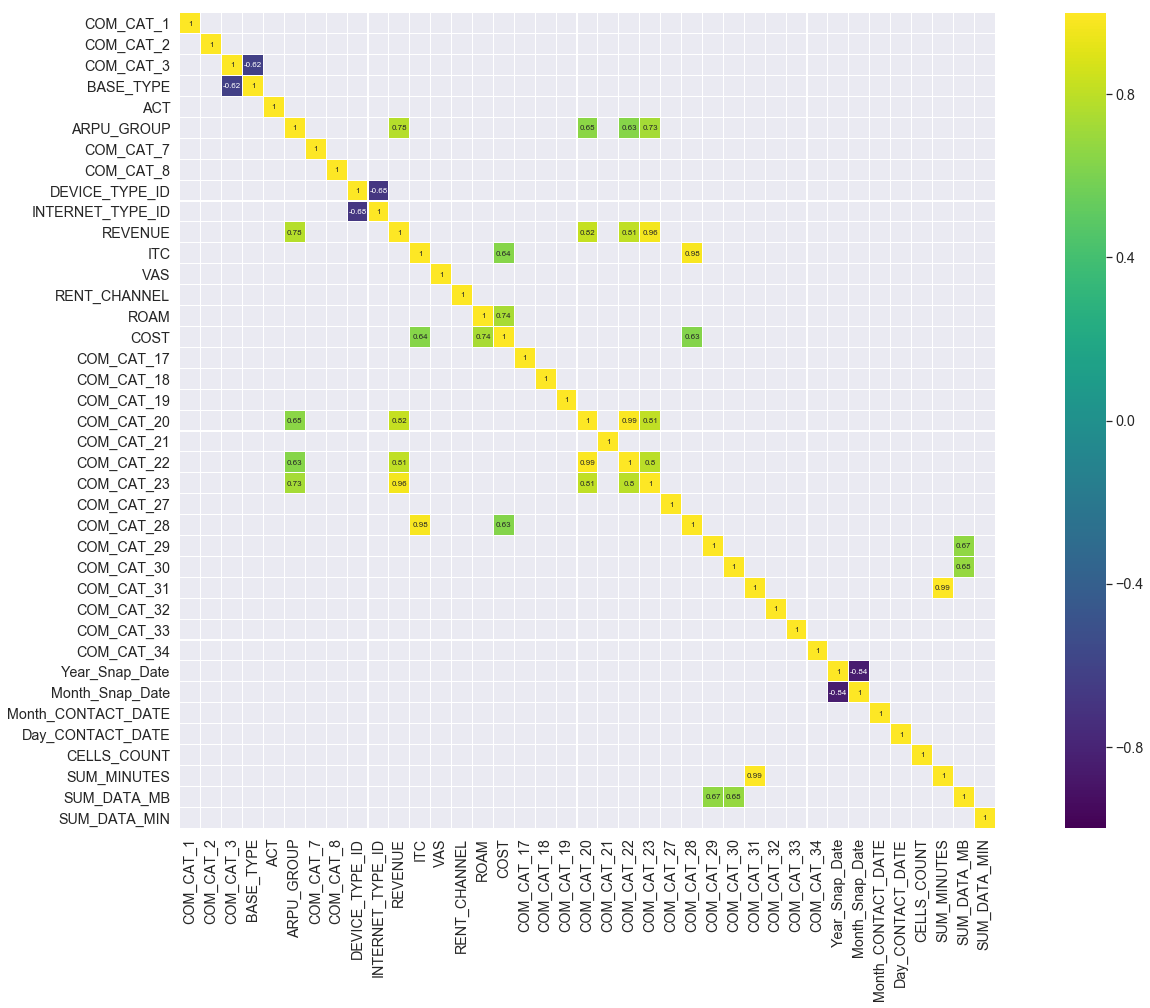

In [47]:
#df_feature_corr = df.drop('CSI_mean', axis = 1).corr(method = 'pearson')
df_feature_corr = df.drop(['CSI', 'SK_ID'], axis = 1).corr(method = 'pearson')

plt.figure(figsize=(25, 15))
sns.heatmap(df_feature_corr[abs(df_feature_corr) > 0.6], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

Выводы из корреляций:
1. Com_cat_3 и Base type коррелированы отрицательно.
2. ARPU Group сильнее всего связан с Revenue и Com Cat 23. ARPU = Total Revenue / # of Users.
3. Device type id and internet type id коррелированы отрицательно.
4. Revenue связан с ARPU Group и Com Cat 20, Com Cat 22 и Com Cat 23.
5. ITC с Com Cat 28.
6. ROAM с COST.
7. COST c Com Cat 28.
8. Com cat 20 c Com Cat 22 и Com Cat 23.

Обратить внимание на VAS - Value Added Services услуги, приносящие дополнительный доход.


Относительно 
- base type
- act
- com cat 17 and 18 19 - обратить внимание
- COM_CAT_20
- COM_CAT_25
- COM_CAT_26
- COM_CAT_29

А если посмотреть датасеты на примере нескольких SK_ID но по разделению трейн-тест.

In [48]:
df.shape

(106400, 41)

In [49]:
# разделим датасеты по индексу, с которого начинается тестовая выборка
test_split_index = df[df.SK_ID == 6184].index[0] 
test_split_index

47411

In [50]:
df_train = df[:test_split_index]
df_test = df[test_split_index:]

In [51]:
#split_index
print ("   train df", "           test df")
print (pd.concat([df_train.Month_CONTACT_DATE.value_counts() ,df_test.Month_CONTACT_DATE.value_counts() ],axis=1))

print (pd.concat([df_train.Month_Snap_Date.value_counts() ,df_test.Month_Snap_Date.value_counts() ],axis=1))

   train df            test df
   Month_CONTACT_DATE  Month_CONTACT_DATE
4                 NaN               55317
5             47411.0                3672
    Month_Snap_Date  Month_Snap_Date
1              4001             5037
2              4044             5090
3              4105             5169
4              4172             5197
5              4200             4653
6              3711             4656
7              3755             4729
8              3797             4794
9              3845             4844
10             3891             4892
11             3922             4935
12             3968             4993


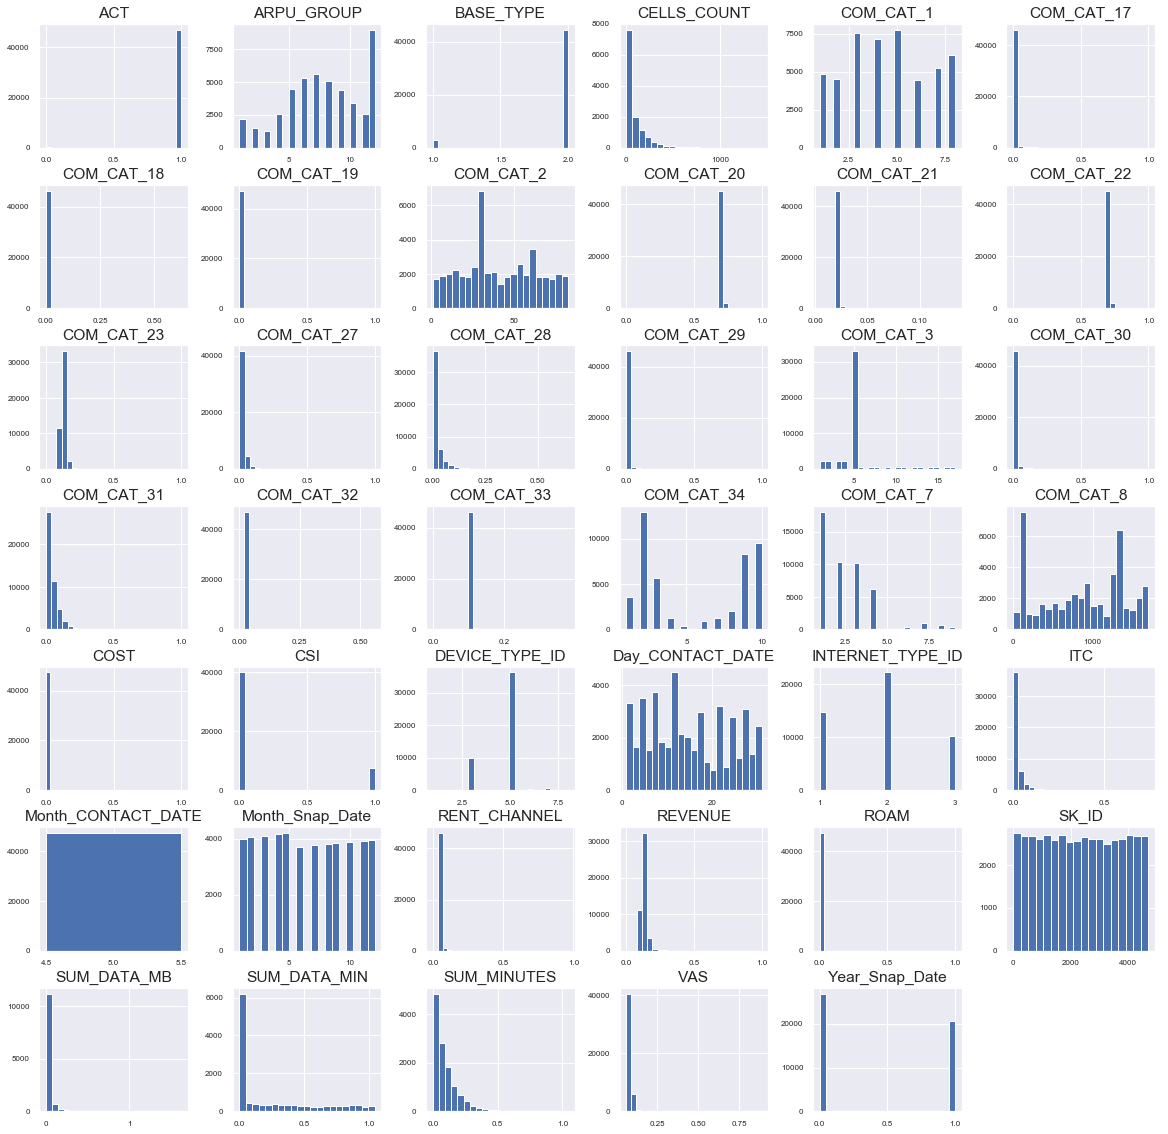

In [52]:
df_train.hist(figsize=(20, 20), bins='doane', xlabelsize=8, ylabelsize=8);

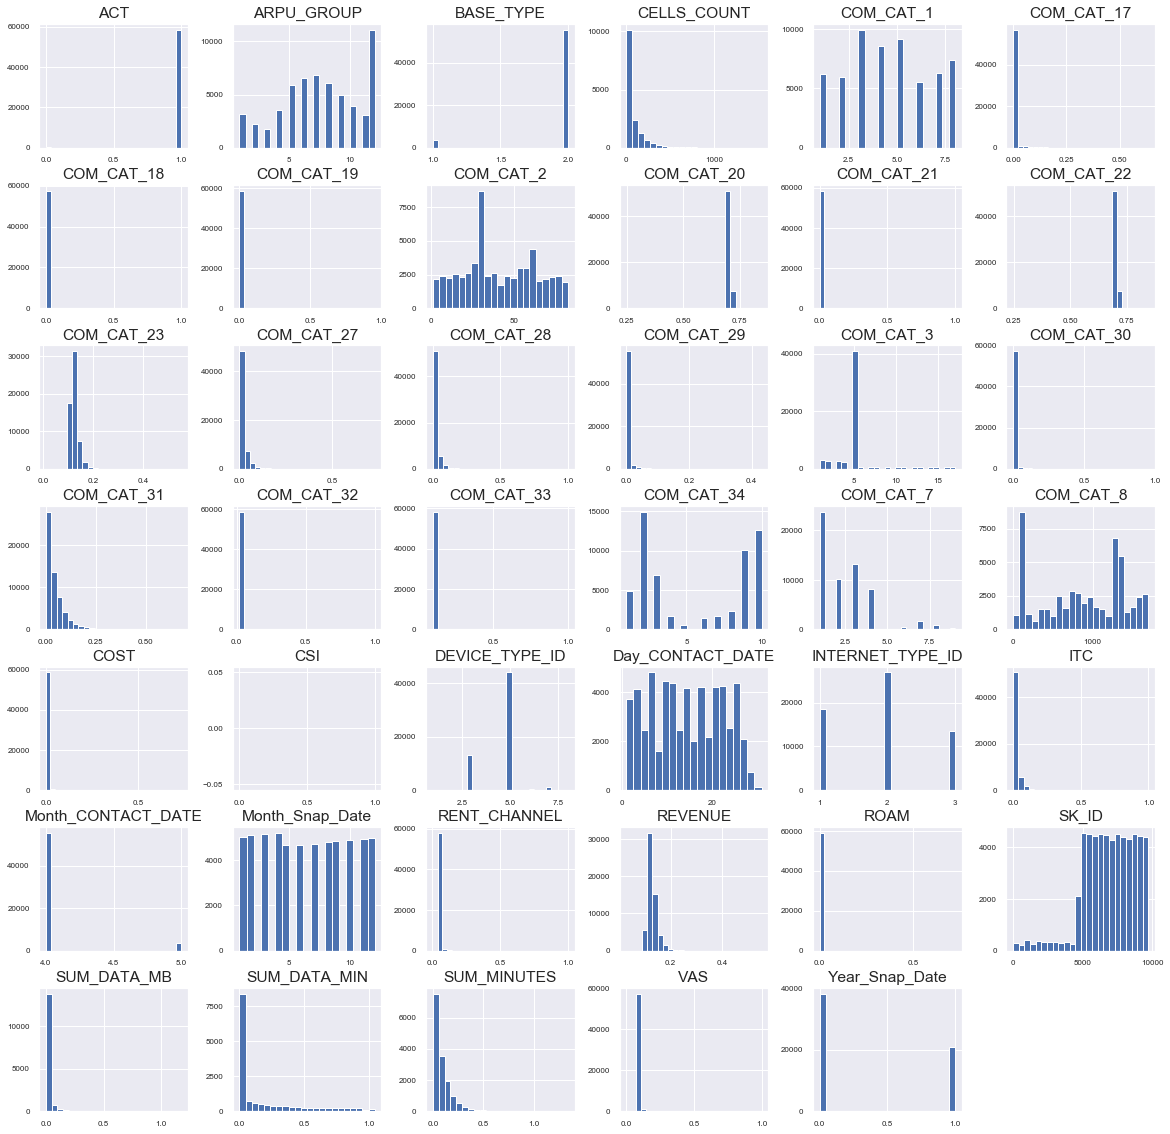

In [53]:
df_test.hist(figsize=(20, 20), bins='doane', xlabelsize=8, ylabelsize=8);

Т.е. получается, что мы тренируемся на данных за Май(5 месяц опроса), тогда как предсказать должны за клиентов по апрелю(4 месяц опроса).

Судя по виду графиков, кардинальных отличий не заметно.

Не стоит забывать про одну человеческую особенность - маловероятно,что абонент будет помнить про то, что было год назад и поэтому стоит учитывать, что возможно будут важны данные только за последние 3 месяца (как в таблице bs_consumption).

ВОЗМОЖНО: следует откинуть все кроме последнего месяца и дня опроса и это даст наилучший результат.
Таким образом можно выдвинуть гипотезу, что для получения наилучших результатов будем аггрегировать:
 - отрежем данные за предыдущие 9 месяцев в основной таблице
  - данные из сторонних таблиц сначала сгруппируем по месяцу и подключим к основной таблице

Посмотрим на изменение данных по месяцам по нескольким признакам (различные признаки, связанные с ценой и объемом потребляемых услуг).

Посмотрим изменение признака COST.

E:\Python\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


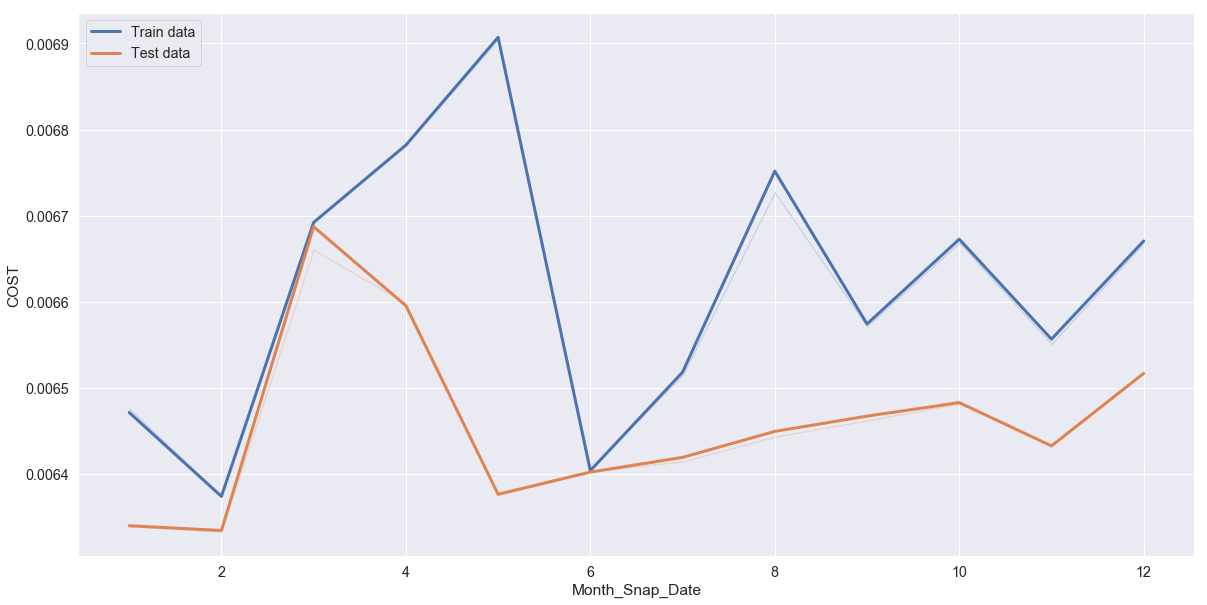

In [54]:
plt.figure(figsize=(20, 10))
#sns.boxplot(x=df.Day_CONTACT_DATE,y=df.SK_ID, hue='CSI', data=df)
sns.lineplot(x=df_train.Month_Snap_Date, y=df_train.COST, data=df_train, ci = 0,label="Train data",lw=3)
sns.lineplot(x=df_test.Month_Snap_Date, y=df_test.COST, data=df_test, ci = 0,label="Test data",lw=3)
plt.legend(loc='upper left')

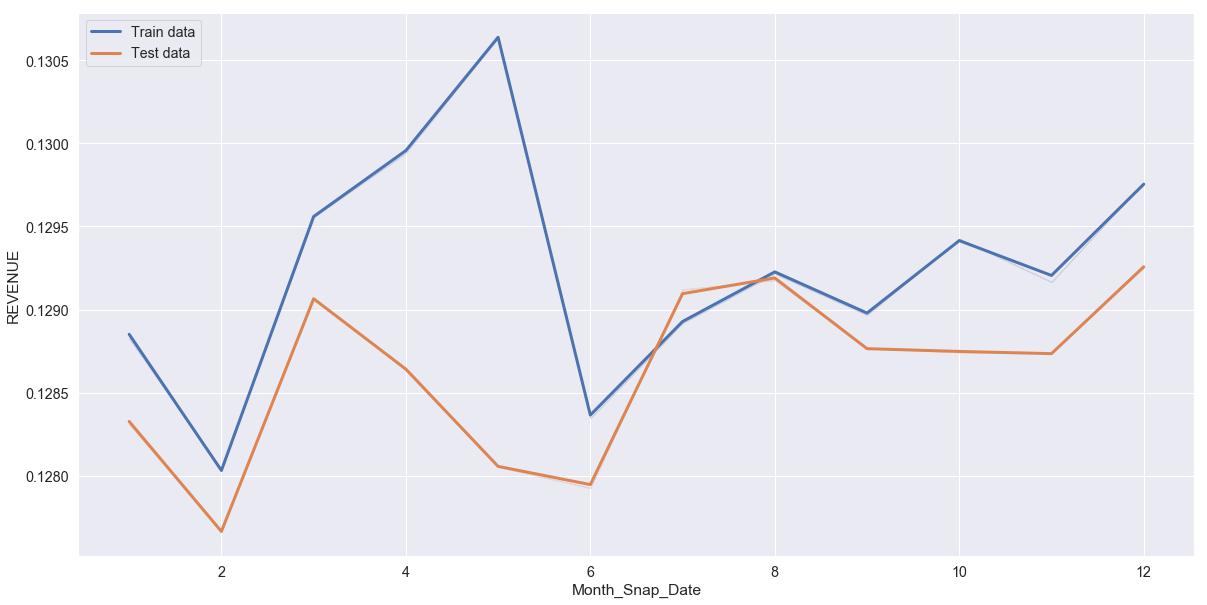

In [55]:
plt.figure(figsize=(20, 10))
#sns.boxplot(x=df.Day_CONTACT_DATE,y=df.SK_ID, hue='CSI', data=df)
sns.lineplot(x=df_train.Month_Snap_Date, y=df_train.REVENUE, data=df_train, ci = 0,label="Train data",lw=3)
sns.lineplot(x=df_test.Month_Snap_Date, y=df_test.REVENUE, data=df_test, ci = 0,label="Test data",lw=3)
plt.legend(loc='upper left')

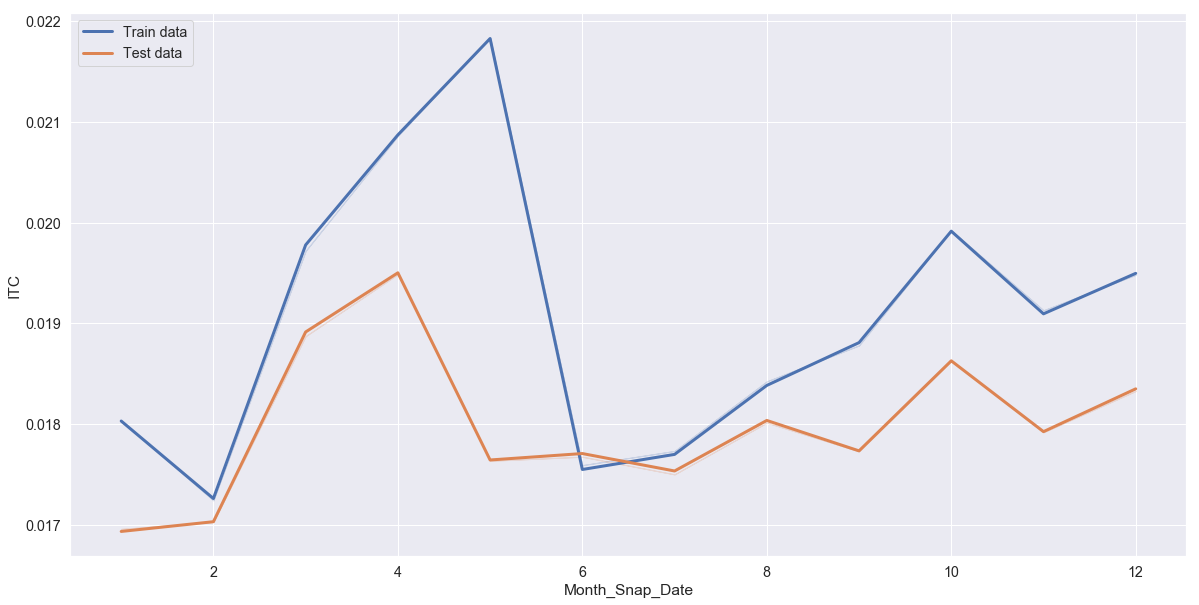

In [56]:
plt.figure(figsize=(20, 10))
#sns.boxplot(x=df.Day_CONTACT_DATE,y=df.SK_ID, hue='CSI', data=df)
sns.lineplot(x=df_train.Month_Snap_Date, y=df_train.ITC, data=df_train, ci = 0,label="Train data",lw=3)
sns.lineplot(x=df_test.Month_Snap_Date, y=df_test.ITC, data=df_test, ci = 0,label="Test data",lw=3)
plt.legend(loc='upper left')

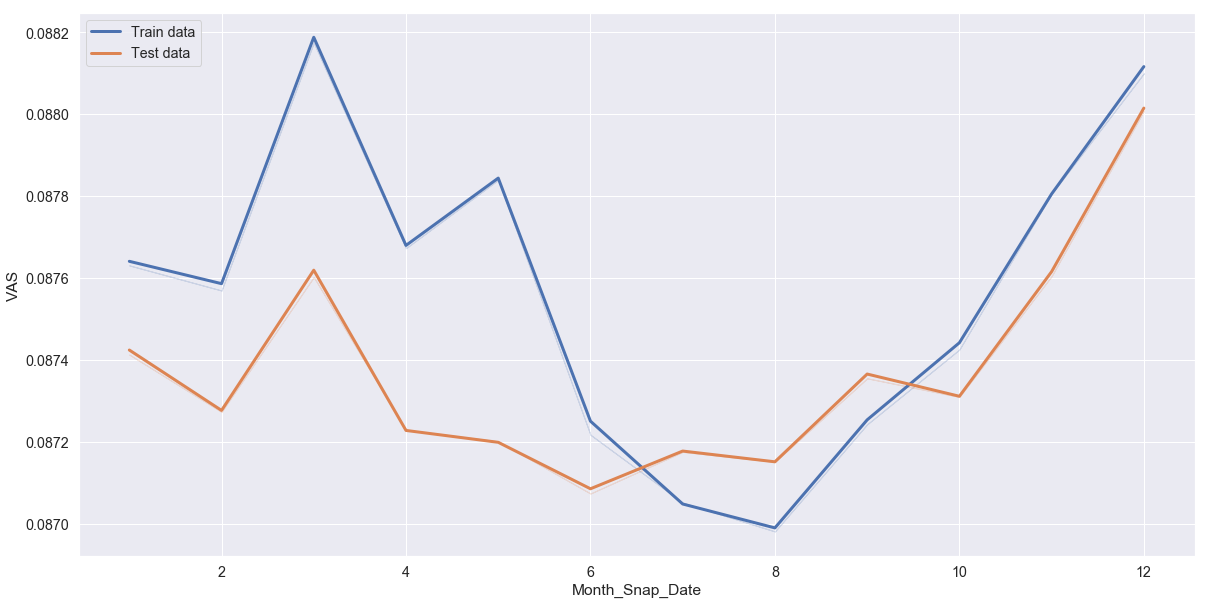

In [57]:
plt.figure(figsize=(20, 10))
#sns.boxplot(x=df.Day_CONTACT_DATE,y=df.SK_ID, hue='CSI', data=df)
sns.lineplot(x=df_train.Month_Snap_Date, y=df_train.VAS, data=df_train, ci = 0,label="Train data",lw=3)
sns.lineplot(x=df_test.Month_Snap_Date, y=df_test.VAS, data=df_test, ci = 0,label="Test data",lw=3)
plt.legend(loc='upper left')

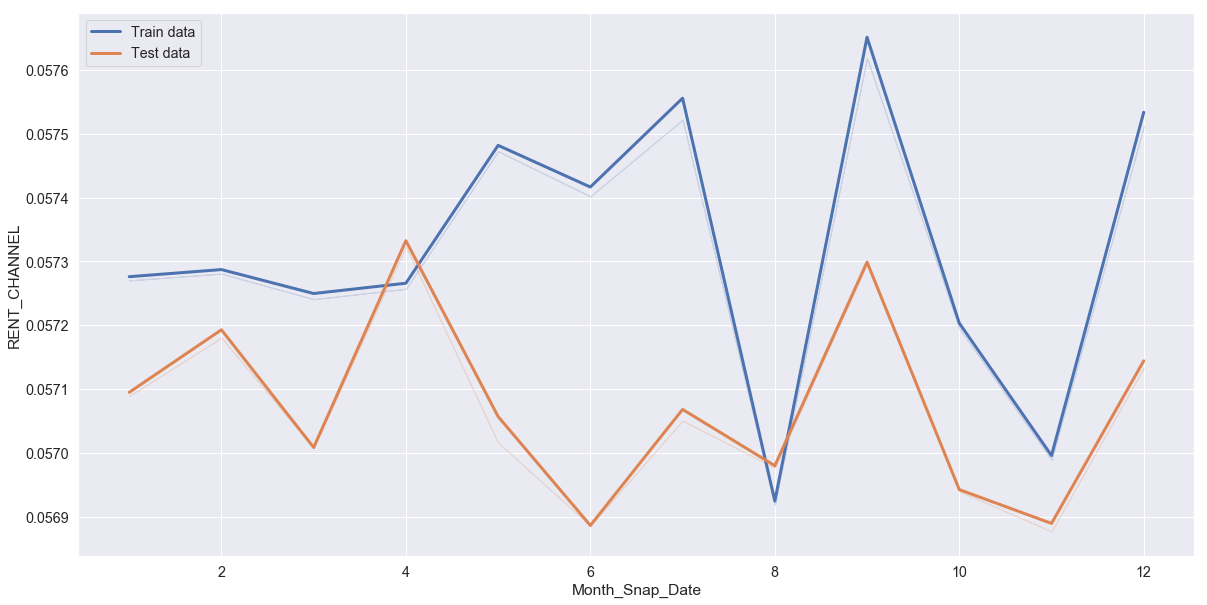

In [58]:
plt.figure(figsize=(20, 10))
#sns.boxplot(x=df.Day_CONTACT_DATE,y=df.SK_ID, hue='CSI', data=df)
sns.lineplot(x=df_train.Month_Snap_Date, y=df_train.RENT_CHANNEL, data=df_train, ci = 0,label="Train data",lw=3)
sns.lineplot(x=df_test.Month_Snap_Date, y=df_test.RENT_CHANNEL, data=df_test, ci = 0,label="Test data",lw=3)
plt.legend(loc='upper left')

Тренды в большинстве своем схожи, и наблюдаются пики, в некоторых месяцах. Сложно предположить, что это даст какую-либо полезную информацию.

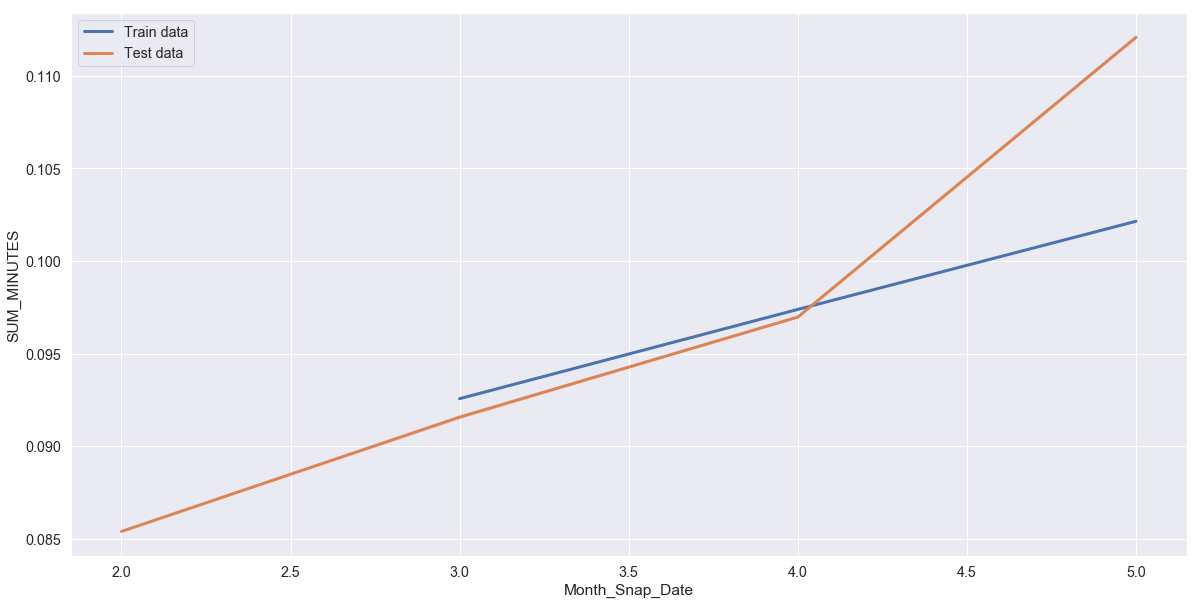

In [59]:
plt.figure(figsize=(20, 10))
#sns.boxplot(x=df.Day_CONTACT_DATE,y=df.SK_ID, hue='CSI', data=df)
sns.lineplot(x=df_train.Month_Snap_Date, y=df_train.SUM_MINUTES, data=df_train, ci = 0,label="Train data",lw=3)
sns.lineplot(x=df_test.Month_Snap_Date, y=df_test.SUM_MINUTES, data=df_test, ci = 0,label="Test data",lw=3)
plt.legend(loc='upper left')

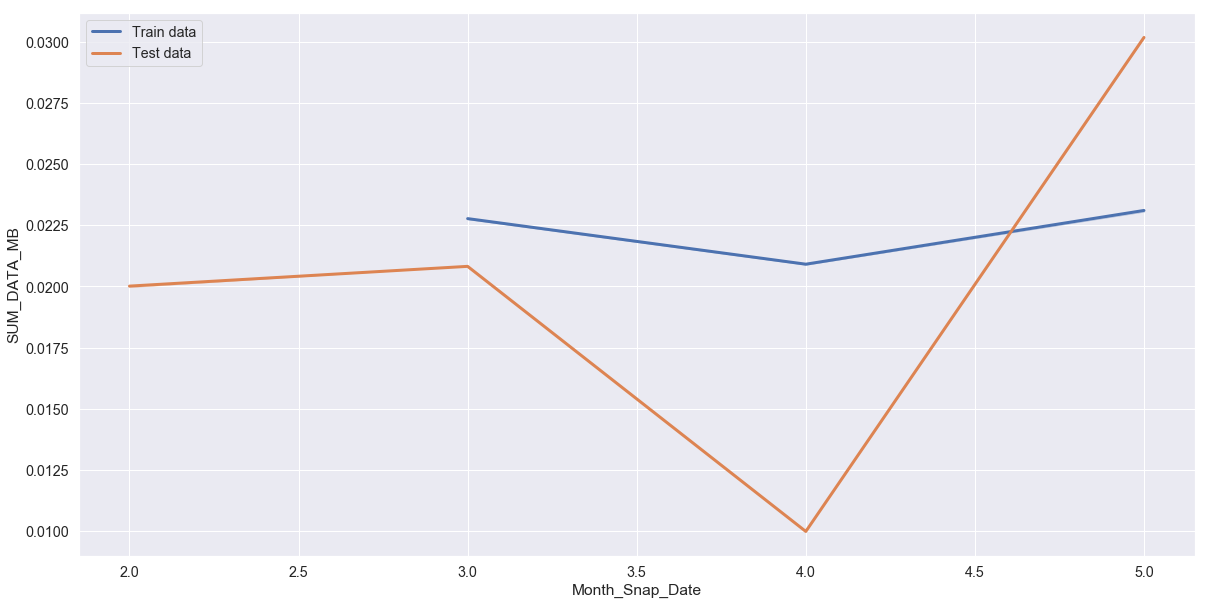

In [60]:
plt.figure(figsize=(20, 10))
#sns.boxplot(x=df.Day_CONTACT_DATE,y=df.SK_ID, hue='CSI', data=df)
sns.lineplot(x=df_train.Month_Snap_Date, y=df_train.SUM_DATA_MB, data=df_train, ci = 0,label="Train data",lw=3)
sns.lineplot(x=df_test.Month_Snap_Date, y=df_test.SUM_DATA_MB, data=df_test, ci = 0,label="Test data",lw=3)
plt.legend(loc='upper left')

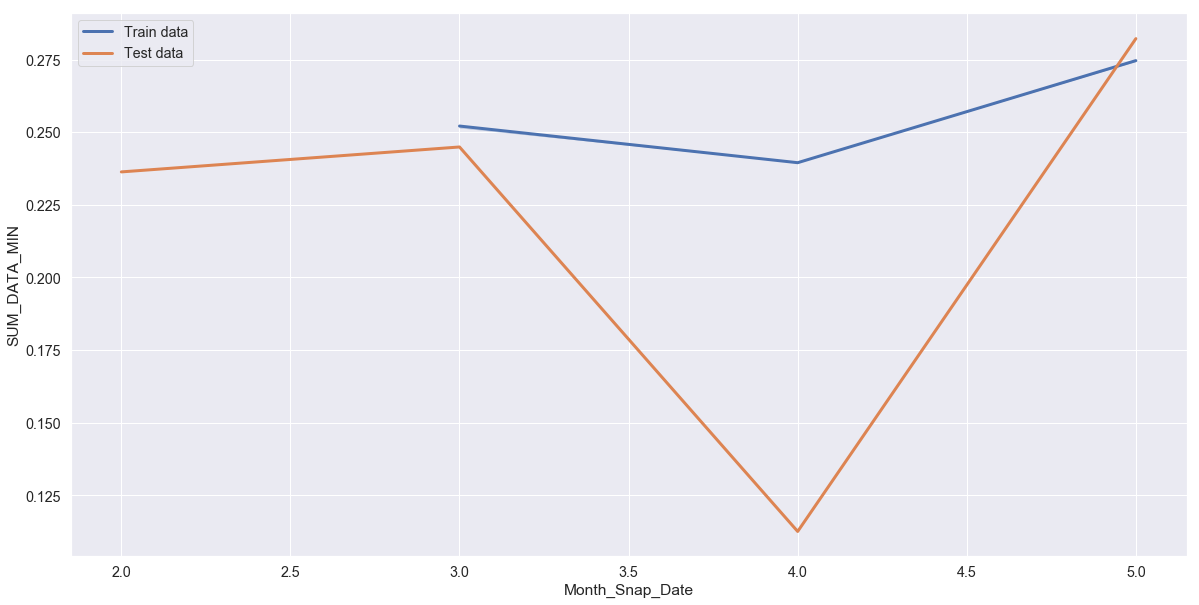

In [61]:
plt.figure(figsize=(20, 10))
#sns.boxplot(x=df.Day_CONTACT_DATE,y=df.SK_ID, hue='CSI', data=df)
sns.lineplot(x=df_train.Month_Snap_Date, y=df_train.SUM_DATA_MIN, data=df_train, ci = 0,label="Train data",lw=3)
sns.lineplot(x=df_test.Month_Snap_Date, y=df_test.SUM_DATA_MIN, data=df_test, ci = 0,label="Test data",lw=3)
plt.legend(loc='upper left')

tbd

#### Target analysis.

In [62]:
df.CSI.value_counts()

0.0    39982
1.0     7429
Name: CSI, dtype: int64

In [63]:
df.shape

(106400, 41)

Класс несбалансирован, количесво "довольных" клиентов больше, чем недовольных.

Посмотрим на вид целевой переменной в зависимости от других признаков.

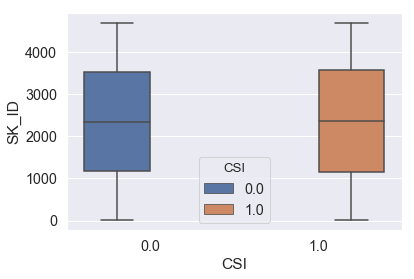

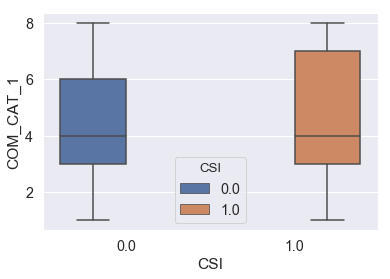

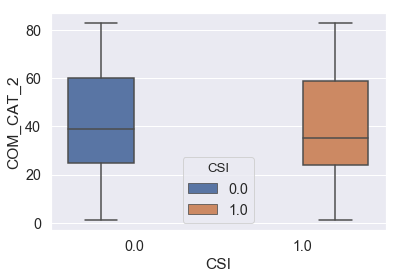

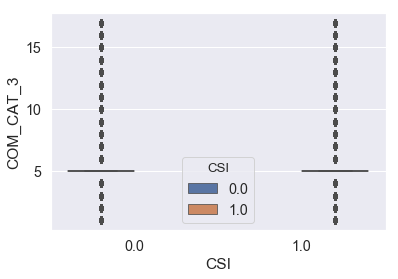

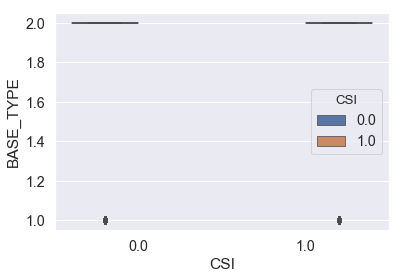

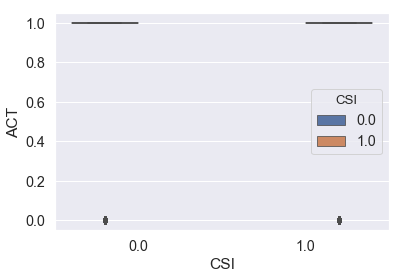

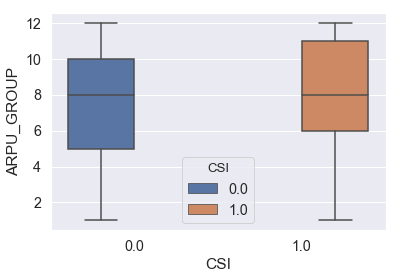

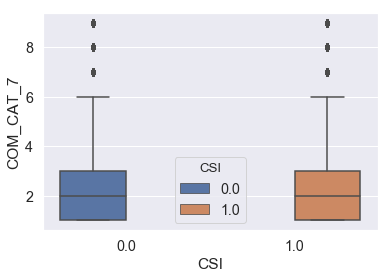

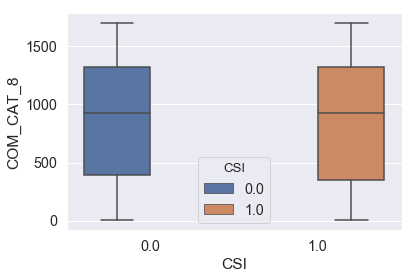

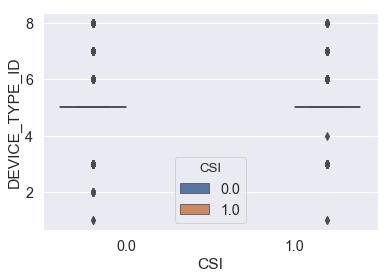

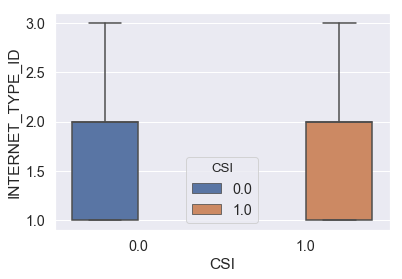

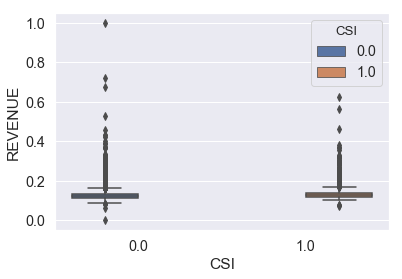

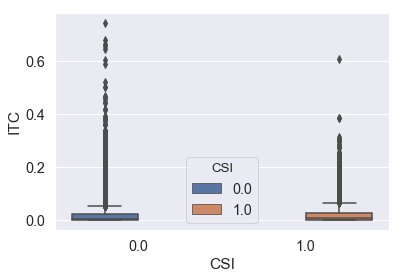

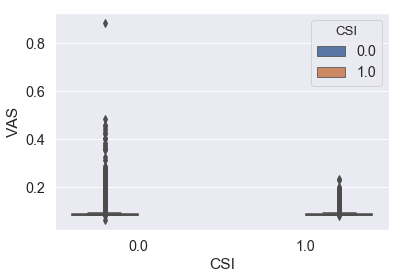

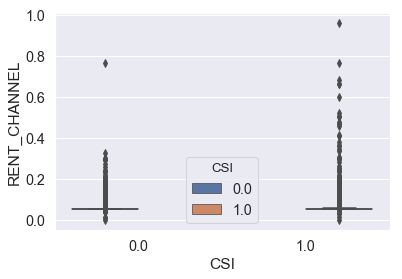

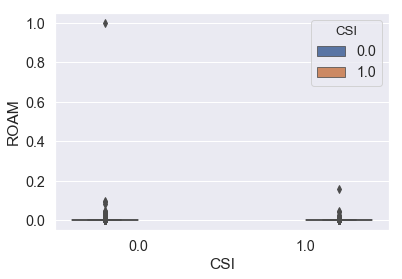

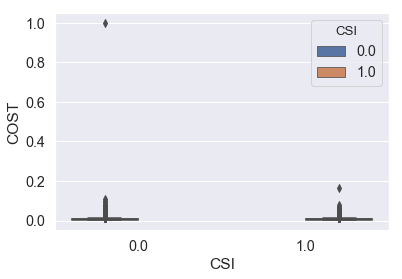

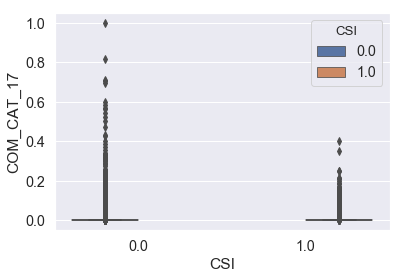

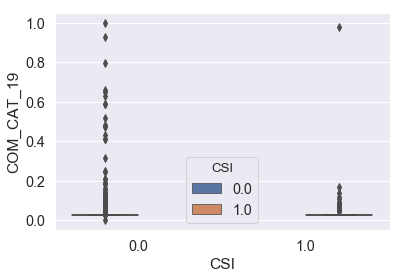

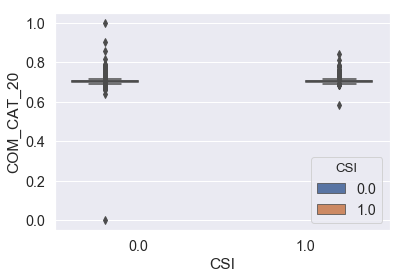

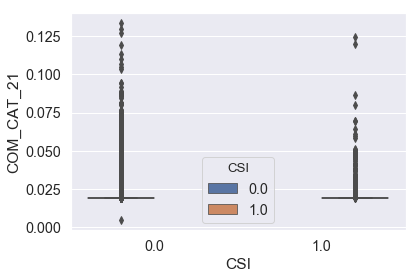

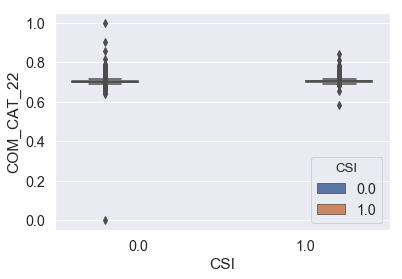

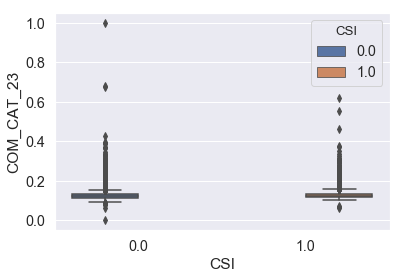

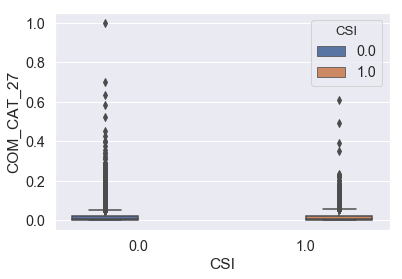

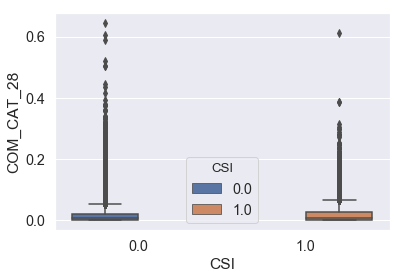

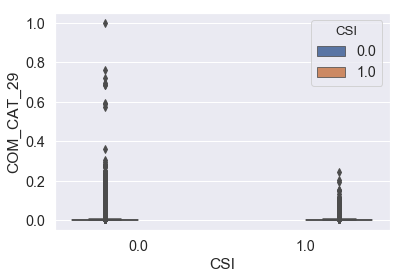

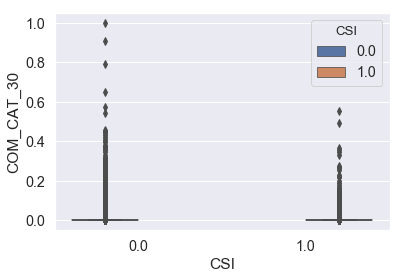

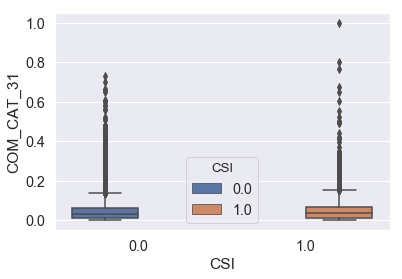

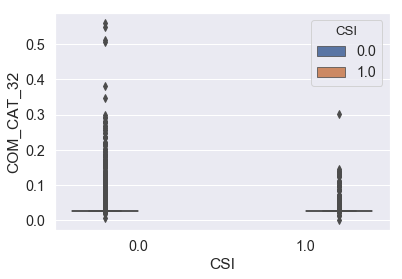

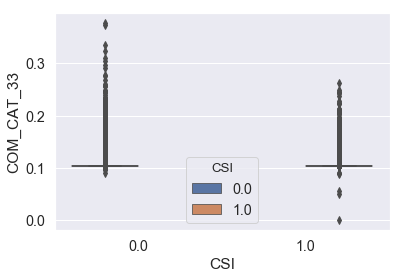

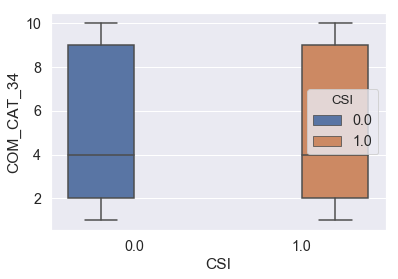

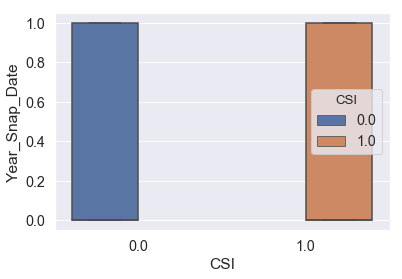

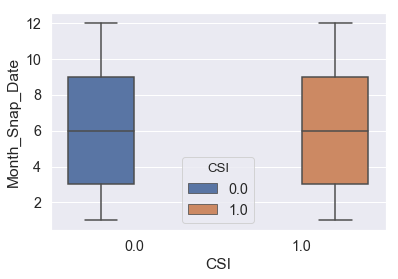

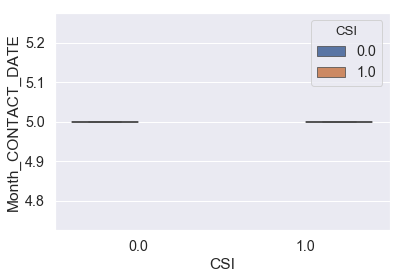

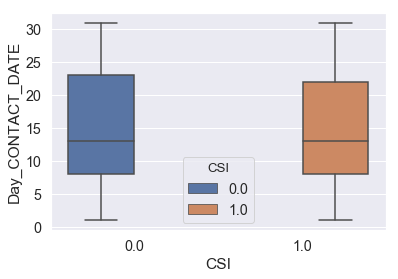

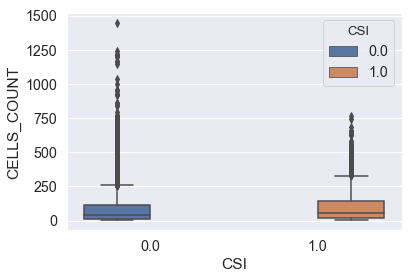

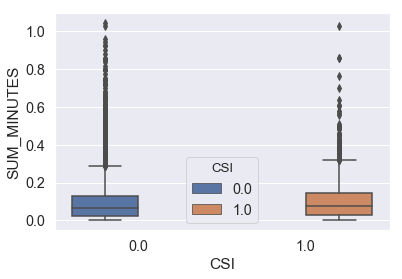

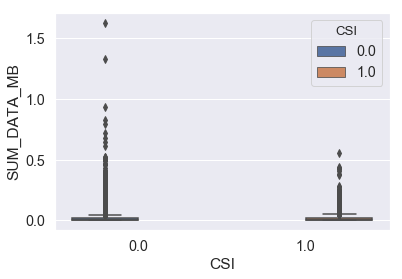

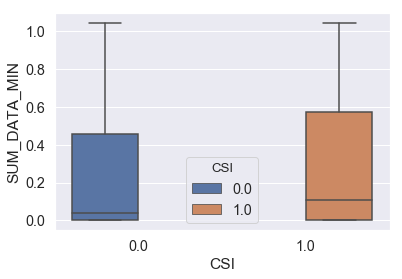

In [67]:
for i, col in enumerate(df.columns.drop([target,'COM_CAT_18'])):
    #plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[target],y=df[col], hue='CSI', data=df)
    plt.show()

В одном из решений, была мысль разбить по бинам часть признаков, частоты которых распределены более-менее равномерно.

Но это не привело к какому-либо существенному увеличению скора.

In [ ]:
'''
df['COM_CAT_20'] = pd.cut(df.COM_CAT_20, 12, labels = False)
df['COM_CAT_22'] = pd.cut(df.COM_CAT_22, 12, labels = False)
df['COM_CAT_23'] = pd.cut(df.COM_CAT_23, 8, labels = False)
df['COM_CAT_27'] = pd.cut(df.COM_CAT_27, 8, labels = False)
df['COM_CAT_28'] = pd.cut(df.COM_CAT_28, 8, labels = False)
df['COM_CAT_31'] = pd.cut(df.COM_CAT_31, 8, labels = False)
'''

Факты:
    - Base type = 1 , старая абонентская база (0) более недовольны
    - COM_CAT_1 = 1,3,8 более недовольны
    - ARPU_GROUP 1,2,5,11,12 более недовольны
    - COM_CAT_34 есть несколько недовольных групп 1,5,8,9.
    - COM_CAT_26 равные 0 более недовольны
    - DEVICE_TYPE_ID 7,8 недовольны более всего
    - +VAS можно заенкодить по нескольким основным значениям
    - Признаки: VAS,Roam,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_21,COM_CAT_29,COM_CAT_30,COM_CAT_32,COM_CAT_33 
    расределены, таким образом, что большинство большей частотой обладает 1 значение.
    - COM_CAT_20,COM_CAT_22,COM_CAT_23, COM_CAT_27,COM_CAT_28,COM_CAT_31 - частоты значений распределены более-менее равномерно.
    
    

Соберем данные, по SK_ID за все месяца, при помощи различных аггрегаций.

In [68]:
# сделаем бекап сформированного датасета
backup_df_main = df.copy()

Т.к. процесс происходил циклически - добавление признаков/изменение функций по которым производится агрегация/запуск  алгоритма, то периодически требуется откат назад и восстановление исходного набора данных, для этого и потребуется бекап данных.

In [84]:
#restore df
df = backup_df_main.copy()

In [85]:
#def get_len_unique(test_obj):
#    return len(test_obj.unique())

df = df.groupby(['SK_ID'],sort=False,as_index = False).agg({
    'CSI' : ['mean'],
    #'Year_Snap_Date': [get_len_unique], # v1 disable
    #'Month_Snap_Date': 'count', # v1 disable
    'Month_CONTACT_DATE' : 'first', # v1 disable
    'Day_CONTACT_DATE' : 'first',
    'COM_CAT_1': ['mean'],
    'COM_CAT_2': 'mean', 
    'COM_CAT_3' :'mean',
    'BASE_TYPE' : 'first',
    'ACT' : 'median',
    'ARPU_GROUP' : ['median'], # tt
    'COM_CAT_7': 'first',
    'COM_CAT_8' : 'mean',
    'DEVICE_TYPE_ID' : 'first',
    'INTERNET_TYPE_ID' : 'first', 
    'REVENUE' : 'max', # tt
    'ITC' : 'max',
    'VAS' : 'max',
    'RENT_CHANNEL' : 'max',
    'ROAM' : 'max',
    'COST' : 'max',
    #'COM_CAT_17' : 'mean',
    #'COM_CAT_18' : 'mean',
    #'COM_CAT_19' : 'mean',
    'COM_CAT_20' : 'mean', # disable
    #'COM_CAT_21' : 'mean',
    'COM_CAT_22' : 'mean', # disable
    'COM_CAT_23' : 'mean', # disable
    #'COM_CAT_26' : 'mean', v1 disable
    'COM_CAT_27' : 'mean',
    'COM_CAT_28' : 'mean', # tt
    'COM_CAT_29' : 'mean', # tt
    #'COM_CAT_30' : 'mean', # disable
    #'COM_CAT_31' : 'mean', # disable
    #'COM_CAT_32' : 'mean', # disable
    #'COM_CAT_33' : 'mean', # disable
    #'COM_CAT_34' : 'mean', # tt
    'CELLS_COUNT' : ['max','min'],
    'SUM_MINUTES' : ['max','min'],
    'SUM_DATA_MB' : ['max','min'],
    'SUM_DATA_MIN' : 'mean',
})
df.columns = ["_".join(x) for x in df.columns.ravel()]

Новые признаки формировались исходя из набора признаков, которые выдавались при помощи SelectKBest и предметной области, лучшее решение (исходя из публичного рейтинга) было построено по следующим признакам и аггрегациям.

Новые признаки были построены исходя из таких гипотез:
- суммарная стоимость и использование ресурсов могут повлиять на то, доволен клиент или нет.
- признаки COM_CAT_20_mean, COM_CAT_22_mean,df.COM_CAT_23_mean коррелируют между собой и было принято решение их усреднить и объединить в один.
- аналогично поступить и с  COM_CAT_27_mean, COM_CAT_29_mean.

In [87]:
df['AGG_Cost'] = (df.RENT_CHANNEL_max + df.REVENUE_max + df.ITC_max +
                   df.COST_max + df.VAS_max + df.ROAM_max)

df['AGG_Usage'] = (df.SUM_DATA_MB_min + df.SUM_DATA_MIN_mean + df.SUM_MINUTES_min)

df["Max_Cost"] = df[['RENT_CHANNEL_max', 'REVENUE_max','ITC_max','COST_max', 'VAS_max','ROAM_max']].max(axis=1)

df["Max_Usage"] = df[['SUM_DATA_MB_max', 'SUM_MINUTES_max','SUM_DATA_MIN_mean']].max(axis=1)

df['agg_20_22_23'] = np.mean([df.COM_CAT_20_mean,df.COM_CAT_22_mean,df.COM_CAT_23_mean])

df['agg_27_29'] = np.mean([df.COM_CAT_27_mean,df.COM_CAT_29_mean])

df.drop(['COM_CAT_20_mean','COM_CAT_22_mean','COM_CAT_23_mean'], axis = 1, inplace = True)

df.drop(['COM_CAT_27_mean','COM_CAT_29_mean'], axis = 1, inplace = True)


In [89]:
# проверка что CSI, корректно выбрался и не смешался
df[(df.CSI_mean < 1) & (df.CSI_mean > 0)]

,SK_ID_,CSI_mean,Month_CONTACT_DATE_first,Day_CONTACT_DATE_first,COM_CAT_1_mean,COM_CAT_2_mean,COM_CAT_3_mean,BASE_TYPE_first,ACT_median,ARPU_GROUP_median,COM_CAT_7_first,COM_CAT_8_mean,DEVICE_TYPE_ID_first,INTERNET_TYPE_ID_first,REVENUE_max,ITC_max,VAS_max,RENT_CHANNEL_max,ROAM_max,COST_max,COM_CAT_28_mean,CELLS_COUNT_max,CELLS_COUNT_min,SUM_MINUTES_max,SUM_MINUTES_min,SUM_DATA_MB_max,SUM_DATA_MB_min,SUM_DATA_MIN_mean,AGG_Cost,AGG_Usage,Max_Cost,Max_Usage,agg_20_22_23,agg_27_29


Для удобства также были созданы 2 функции, для построения кривой roc и вывода результатов работы классфикатора.

In [98]:
def plot_curve(fpr, tpr):
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [100]:
def classify(estimator, X_train, X_test, y_train, y_test, return_prob):
    if (return_prob == True): # ветка, когда требуется вернуть вероятности принадлежности классу
        y_pred_train = estimator.predict_proba(X_train)
        y_pred_test = estimator.predict_proba(X_test)
        
        print ("on train")
        print(classification_report(y_train, estimator.predict(X_train)))
        print ("AUC train")
        fpr, tpr, _ = roc_curve(y_train, y_pred_train[:, 1])
        print (auc(fpr, tpr))
        plot_curve(fpr, tpr)
        return y_pred_test[:, 1]
    elif(return_prob == False):# ветка, когда трейн дополнительно разделялся на трейн-тест
        y_pred_train = estimator.predict_proba(X_train)
        y_pred_test = estimator.predict_proba(X_test)
        
        print ("on train")
        print(classification_report(y_train, estimator.predict(X_train)))
        print ("AUC train")
        fpr, tpr, _ = roc_curve(y_train, y_pred_train[:, 1])
        print (auc(fpr, tpr))
        
        print ("on test")
        print(classification_report(y_test, estimator.predict(X_test)))
        print ("AUC test")
        fpr, tpr, _ = roc_curve(y_test, y_pred_test[:, 1])
        print (auc(fpr, tpr))

#### Baseline.

Разделим данные обратно на тест/трейн.

In [90]:
split_index = df[df.SK_ID_ == 6184].index[0] 

y = df['CSI_mean']

X_train,X_test = df[:split_index].drop(['CSI_mean','SK_ID_'], axis = 1),df[split_index:].drop(['CSI_mean','SK_ID_'], axis = 1)

y_train = y[:split_index]

Настроим единую предобработку и заполнение пропусков.

In [91]:
df_num_features = list(df).copy()
df_num_features.remove('CSI_mean')
df_num_features.remove('SK_ID_')
#df_num_features

num_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='median',copy = False)), # with median a little bit better
    ('scale', MinMaxScaler()),
    ('transform', QuantileTransformer(output_distribution='normal'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_features_pipeline, df_num_features),
        #('cat_ext', cat_ext_features_pipeline, cat_ext),
        #('cat_bin', cat_bin_features_pipeline, cat_bin)
    ]
)

#### SVC.

In [92]:
anova_filter = SelectKBest(f_classif, k = 13) # yet the best decision 0.5580 auc, k = 19, C = 0.4
#poly = PolynomialFeatures(3)

# 17 and ft to 3

svc = SVC(kernel = 'rbf',
          gamma = 'scale',
          C = 0.35, #uncommitted
          random_state = seed,          
          decision_function_shape = 'ovr',                             
          class_weight = 'balanced',     
          probability = True)

baseline_SVC = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        #('t_svd',svd),
        ('anova' , anova_filter),
        ('classify', svc)
    ]
)


cvs_classify = baseline_SVC.fit(X_train, y_train)

0.5647352225508206

Кросс валидацию будет проводиться на 10 фолдах с перемешиванием, итоговые оценки будут усредняться.

Как показала практика, это не особо помогло в борьбе с переобучением (исходя из оценки на leaderboard, после публикации private rating'a).

In [94]:
skv = StratifiedKFold(n_splits = 10,random_state=seed, shuffle=True)
cross_val_score(cvs_classify, X_train, y_train, cv=skv, scoring='roc_auc',n_jobs = -1).mean()

0.5647352225508206

Выведем K лучшие фичи из пайплайна. 

In [96]:
ft = cvs_classify.named_steps['anova'].get_support()
X_train.columns[ft]

Index(['ARPU_GROUP_median', 'REVENUE_max', 'ITC_max', 'RENT_CHANNEL_max',
       'COST_max', 'COM_CAT_28_mean', 'CELLS_COUNT_max', 'SUM_DATA_MB_max',
       'SUM_DATA_MIN_mean', 'AGG_Cost', 'AGG_Usage', 'Max_Cost', 'Max_Usage'],
      dtype='object')

Исходя из этих фич, циклически производилась работа над использующихся в аггрегации функций и добавления новых фич.

In [ ]:
y_test = 0
results = classify(cvs_classify, X_train, X_test, y_train, y_test, True)
#results = classify(cvs_classify, X_sub_train, X_sub_test, y_sub_train, y_sub_test, False)

results.shape
results = pd.DataFrame(results)

сохраним результаты в файл.

In [ ]:
results.to_csv("results/out_svc_reworked_v13.csv", sep='\t', encoding='utf-8',index = False, header = False)

Произведем подбор гиперпараметров.

In [97]:
my_scorer = make_scorer(roc_auc_score)
skv = StratifiedKFold(n_splits = 10,random_state=seed, shuffle=True)

param_grid = {
             'classify__C': np.arange(0.05, 1.2, 0.1),
             'anova__k': np.arange(11, 19, 1)
             }


bclf = GridSearchCV(baseline_SVC, param_grid,
                   scoring=my_scorer, cv=skv, verbose=9, n_jobs=-1,refit='roc_auc')



In [ ]:
%%time
bclf.fit(X_train, y_train)

In [ ]:
bclf.best_params_

In [ ]:
baseline_SVC.set_params(** bclf.best_params_)

In [ ]:
svc_with_best_params = baseline_SVC.fit(X_train, y_train)

Произведем повторно кросс-валидацию.

In [ ]:
skv = StratifiedKFold(n_splits = 10,random_state=seed, shuffle=True)
cross_val_score(svc_with_best_params, X_train, y_train, cv=skv, scoring='roc_auc',n_jobs = -1).mean()

In [ ]:
y_test = 0
results = classify(cvs_classify, X_train, X_test, y_train, y_test, True)
#results = classify(cvs_classify, X_sub_train, X_sub_test, y_sub_train, y_sub_test, False)

results.shape
results = pd.DataFrame(results)

сохраним результаты в файл.

In [ ]:
results.to_csv("results/out_svc_reworked_v13.csv", sep='\t', encoding='utf-8',index = False, header = False)

Для решения также использовались RandomForest, LogisticRegression, XGBoost.
Но т.к. SVC с ядром RBF стала показывать улучшение решения на публичном рейтинге, то решено было сконцентрироваться на нём.

#### Random Forest.

In [ ]:
dtree = RandomForestClassifier(
    n_estimators=500,
    max_depth=5,
    min_samples_leaf = 4,
    class_weight = 'balanced',
    n_jobs = -1,
    random_state=0)


baseline_rf = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ('classify', dtree)
    ]
)

rf_classify = baseline_rf.fit(X_train, y_train)

Произведем кросс-валидацию.

In [ ]:
skv = StratifiedKFold(n_splits = 10,random_state=seed, shuffle=True)
cross_val_score(rf_classify, X_train, y_train, cv=skv, scoring='roc_auc',n_jobs = -1).mean()

In [ ]:
y_test = 0
results = classify(cvs_classify, X_train, X_test, y_train, y_test, True)

results.shape
results = pd.DataFrame(results)

сохраним результаты в файл.

In [ ]:
results.to_csv("results/out_rf_v1.csv", sep='\t', encoding='utf-8',index = False, header = False)

Произведем подбор гиперпараметров.

In [ ]:
%%time

my_scorer = make_scorer(roc_auc_score)
skv = StratifiedKFold(n_splits = 10,random_state=seed, shuffle=True)

param_grid = {
             'classify__n_estimators': [5, 50, 100, 200, 400],
             'classify__max_depth': [2, 5, 7, 9],
             'classify__min_samples_leaf': [1,2,3,4]
             }


rf_bclf = GridSearchCV(baseline_rf, param_grid,
                   scoring=my_scorer, cv=skv, verbose=9, n_jobs=-1,refit='roc_auc')

rf_bclf.fit(X_train, y_train)

In [ ]:
rf_bclf.best_params_
best_params_backup_ = {'classify__max_depth': 5,
 'classify__min_samples_leaf': 3,
 'classify__n_estimators': 5}

In [ ]:
baseline_rf.set_params( ** rf_bclf.best_params_)

In [ ]:
rf_with_best_params = baseline_rf.fit(X_train, y_train)

Произведем повторно кросс-валидацию.

In [ ]:
skv = StratifiedKFold(n_splits = 10,random_state=seed, shuffle=True)
cross_val_score(svc_with_best_params, X_train, y_train, cv=skv, scoring='roc_auc',n_jobs = -1).mean()

In [ ]:
y_test = 0
results = classify(cvs_classify, X_train, X_test, y_train, y_test, True)

results.shape
results = pd.DataFrame(results)

сохраним результаты в файл.

In [ ]:
results.to_csv("results/out_rf_v2.csv", sep='\t', encoding='utf-8',index = False, header = False)

#### Logistic Regression.

In [ ]:
clf_log = LogisticRegression(multi_class = 'ovr',
                             solver='liblinear',
                             random_state = seed,
                             n_jobs = -1,
                             max_iter = 10e2,
                             class_weight='balanced',
                             penalty = 'l2'
                            )

In [ ]:
baseline_logit = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ('classify', clf_log)
    ]
)

In [ ]:
logit_regr = baseline_logit.fit(X_train, y_train)

Произведем кросс-валидацию.

In [ ]:
skv = KFold(n_splits = 10,random_state=seed, shuffle=True)
cross_val_score(logit_regr, X_train, y_train, cv=skv, scoring='roc_auc',n_jobs = -1).mean()

In [ ]:
results = classify(logit_regr,X_train, X_test, y_train, y_test, True)

In [ ]:
results.shape
results = pd.DataFrame(results)

In [ ]:
results.to_csv("results/logit_v1.csv", sep='\t', encoding='utf-8',index = False, header = False)

Подбор гиперпараметров.

In [ ]:
%%time

my_scorer = make_scorer(f1_score, average='weighted')
skv = KFold(n_splits = 10,random_state=seed, shuffle=False)

tuned_parameters = [
    {
    'classify__penalty': ['l2'],
    'classify__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20]
                    
                    },
    {
    'classify__penalty': ['l1'],
    'classify__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20]
                    }
    ]


bclf = GridSearchCV(baseline_logit, tuned_parameters,
                   scoring=my_scorer, cv=skv, verbose=9, n_jobs=-1,refit='roc_auc')

bclf.fit(X_train, y_train)

In [ ]:
# временная функция, для постройки графика подбора гиперпаратров
def create_cv_plot(estimator):
    alphas = estimator.cv_results_['param_classify__C'].data
    scores = estimator.cv_results_['mean_train_score']
    combined = pd.DataFrame({'C':alphas, 'score':scores})
    plt.figure(figsize=(18, 10))

    plt.plot(combined.C[0:20], combined.score[0:20],'go-')
    plt.grid(True)
    plt.title('C and metrics plt')
    plt.xlabel('C values') 
    plt.ylabel('mean_train_score error')

In [ ]:
bclf.best_params_

In [ ]:
baseline_logit.set_params(** bclf.best_params_)

In [ ]:
log_with_best_params = baseline_logit.fit(X_train, y_train)

In [ ]:
skv = KFold(n_splits = 10,random_state=seed, shuffle=True)
cross_val_score(log_with_best_params, X_train, y_train, cv=skv, scoring='roc_auc',n_jobs = -1).mean()

In [ ]:
classify(log_with_best_params)

In [ ]:
results = classify(logit_regr,X_train, X_test, y_train, y_test, True)

In [ ]:
results.shape
results = pd.DataFrame(results)

In [ ]:
results.to_csv("results/logit_v1.csv", sep='\t', encoding='utf-8',index = False, header = False)

#### XGBoost.

In [ ]:
# fit model no training data
params={
    'n_estimators':400,
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'gamma':0.1,
    'subsample':0.8,
    'colsample_bytree':0.3,
    'min_child_weight':4,
    'max_depth':5,
    'seed':seed,
    'eval_metric':'auc',
    
    }

xbg_clf = XGBClassifier(**params)

In [ ]:
baseline_logit = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ('classify', xbg_clf)
    ]
)

In [ ]:
xgb = baseline_logit.fit(X_train,y_train)

In [ ]:
skv = KFold(n_splits = 10,random_state=seed, shuffle=True)
cross_val_score(xgb, X_train, y_train, cv=skv, scoring='roc_auc',n_jobs = -1).mean()

In [ ]:
results = classify(xgb,X_train, X_test, y_train, y_test, True)

In [ ]:
results.shape
results = pd.DataFrame(results)

In [ ]:
results.to_csv("results/xgb_v1.csv", sep='\t', encoding='utf-8',index = False, header = False)